## **Import Packages**

In [ ]:
!pip install --upgrade scikit-learn==1.4.0 -q
!pip install --upgrade category_encoders -q
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.8 MB/s eta 0:00:00


In [ ]:
import sklearn
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import mean_absolute_error

import shap
shap.initjs()

## **Dataset**

In [ ]:
# loading dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/adverts.csv'

In [ ]:
adverts = pd.read_csv(file_path)

In [ ]:
print("Data shape :", adverts.shape)

Data shape : (402005, 12)


In [ ]:
adverts.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


In [ ]:
adverts.describe().T

,count,mean,std,min,25%,50%,75%,max
public_reference,402005.0,2.020071e+14,1.691662e+10,2.013072e+14,2.020090e+14,2.020093e+14,2.020102e+14,2.020110e+14
mileage,401878.0,3.774360e+04,3.483172e+04,0.000000e+00,1.048100e+04,2.862950e+04,5.687575e+04,9.999990e+05
year_of_registration,368694.0,2.015006e+03,7.962667e+00,9.990000e+02,2.013000e+03,2.016000e+03,2.018000e+03,2.020000e+03
price,402005.0,1.734197e+04,4.643746e+04,1.200000e+02,7.495000e+03,1.260000e+04,2.000000e+04,9.999999e+06


## **Subsetting the Dataset**

In [ ]:
new_data = adverts.sample(n=90450, random_state = 22)

In [ ]:
new_data.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
19845,202009234112208,43126.0,63,Grey,Hyundai,ix20,USED,2013.0,5936,Hatchback,False,Petrol
92032,202010235339839,32966.0,66,Black,Mercedes-Benz,GLC Class,USED,2017.0,21990,SUV,False,Diesel
360322,202010225318529,52405.0,67,Silver,Mercedes-Benz,C Class,USED,2017.0,13500,Saloon,False,Diesel
150970,202009274259533,35195.0,17,Black,BMW,3 Series,USED,2017.0,13000,Saloon,False,Diesel
114145,202009264257623,89000.0,13,Black,Vauxhall,Corsa,USED,2013.0,2995,Hatchback,False,Petrol


In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90450 entries, 19845 to 283960
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   public_reference       90450 non-null  int64  
 1   mileage                90415 non-null  float64
 2   reg_code               83232 non-null  object 
 3   standard_colour        89192 non-null  object 
 4   standard_make          90450 non-null  object 
 5   standard_model         90450 non-null  object 
 6   vehicle_condition      90450 non-null  object 
 7   year_of_registration   82865 non-null  float64
 8   price                  90450 non-null  int64  
 9   body_type              90261 non-null  object 
 10  crossover_car_and_van  90450 non-null  bool   
 11  fuel_type              90312 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 8.4+ MB


In [ ]:
new_data.shape

(90450, 12)

Small sample of the dataset is selected for modelling to reduce the computational time and cognitive load

# **Dealing with Data Type**

In [ ]:
# Change the crossover_car_and_van to string instead of float

new_data["crossover_car_and_van"] = new_data["crossover_car_and_van"].astype(int).astype(str)

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90450 entries, 19845 to 283960
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   public_reference       90450 non-null  int64  
 1   mileage                90415 non-null  float64
 2   reg_code               83232 non-null  object 
 3   standard_colour        89192 non-null  object 
 4   standard_make          90450 non-null  object 
 5   standard_model         90450 non-null  object 
 6   vehicle_condition      90450 non-null  object 
 7   year_of_registration   82865 non-null  float64
 8   price                  90450 non-null  int64  
 9   body_type              90261 non-null  object 
 10  crossover_car_and_van  90450 non-null  object 
 11  fuel_type              90312 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 9.0+ MB


In [ ]:
new_data.describe()

,public_reference,mileage,year_of_registration,price
count,9.045000e+04,90415.000000,82865.000000,9.045000e+04
mean,2.020071e+14,37730.406360,2015.009932,1.716528e+04
std,1.734837e+10,34772.708987,6.752853,2.631834e+04
min,2.014053e+14,0.000000,999.000000,2.500000e+02
25%,2.020090e+14,10483.000000,2013.000000,7.495000e+03
50%,2.020093e+14,28551.000000,2016.000000,1.250000e+04
75%,2.020102e+14,57000.000000,2018.000000,2.000000e+04
max,2.020110e+14,788072.000000,2020.000000,3.799995e+06


**Checking for Null values in the dataset**

In [ ]:
new_data.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"}).sort_values("Total No. of Missing Values",ascending=False)

,Total No. of Missing Values
year_of_registration,7585
reg_code,7218
standard_colour,1258
body_type,189
fuel_type,138
mileage,35
public_reference,0
standard_make,0
standard_model,0
vehicle_condition,0


**Checking Duplicate values**

In [ ]:
print("Duplicate Values =",new_data.duplicated().sum())

Duplicate Values = 0


**Showing Categorical features**

In [ ]:
new_data.select_dtypes(include=["object"]).head().columns

Index(['reg_code', 'standard_colour', 'standard_make', 'standard_model',
       'vehicle_condition', 'body_type', 'crossover_car_and_van', 'fuel_type'],
      dtype='object')

**Showing Numerical features**

In [ ]:
new_data.select_dtypes(include=["int","float"]).head()

,public_reference,mileage,year_of_registration,price
19845,202009234112208,43126.0,2013.0,5936
92032,202010235339839,32966.0,2017.0,21990
360322,202010225318529,52405.0,2017.0,13500
150970,202009274259533,35195.0,2017.0,13000
114145,202009264257623,89000.0,2013.0,2995


**Showing Number of unique values**

In [ ]:
new_data["standard_colour"].unique()

array(['Grey', 'Black', 'Silver', 'Multicolour', 'White', 'Blue', nan,
       'Red', 'Orange', 'Beige', 'Green', 'Brown', 'Yellow', 'Purple',
       'Gold', 'Turquoise', 'Burgundy', 'Bronze', 'Pink', 'Maroon',
       'Navy', 'Magenta'], dtype=object)

In [ ]:
new_data["vehicle_condition"].unique()

array(['USED', 'NEW'], dtype=object)

In [ ]:
new_data["standard_make"].unique()

array(['Hyundai', 'Mercedes-Benz', 'BMW', 'Vauxhall', 'SEAT', 'Mazda',
       'Jeep', 'Fiat', 'Toyota', 'SKODA', 'Volkswagen', 'Renault', 'Audi',
       'Lancia', 'Land Rover', 'Nissan', 'Porsche', 'Volvo', 'Peugeot',
       'Subaru', 'MINI', 'Dacia', 'Suzuki', 'Citroen', 'Lexus', 'Kia',
       'MG', 'Jaguar', 'Alfa Romeo', 'Honda', 'Ferrari', 'Maserati',
       'Abarth', 'Bentley', 'Dodge', 'Rolls-Royce', 'Tesla', 'Mitsubishi',
       'Lamborghini', 'Chevrolet', 'Smart', 'DS AUTOMOBILES', 'Saab',
       'Rover', 'Daihatsu', 'McLaren', 'Chrysler', 'Aston Martin',
       'Infiniti', 'SsangYong', 'Noble', 'Alpine', 'Lincoln', 'TVR',
       'Isuzu', 'Caterham', 'Lotus', 'London Taxis International',
       'Radical', 'Corvette', 'GMC', 'Daimler', 'Perodua', 'Triumph',
       'Cadillac', 'Holden', 'Proton', 'Austin', 'Morgan', 'Hummer',
       'CUPRA', 'Great Wall', 'Jensen', 'Morris', 'Beauford', 'Tiger',
       'Westfield', 'Aixam', 'LEVC', 'Bugatti', 'Zenos', 'Custom Vehicle',
       'A

In [ ]:
new_data["standard_model"].unique()

array(['ix20', 'GLC Class', 'C Class', '3 Series', 'Corsa', 'Arona',
       'Mazda2', 'Ioniq', 'Renegade', 'Z4', 'Panda', 'iQ', 'A Class',
       'Mazda6', 'Octavia', 'Golf', 'Clio', '2 Series', 'A3', '1 Series',
       'SQ5', 'Delta', 'Range Rover Evoque', 'Qashqai', 'Prius', 'Macan',
       'A6 Saloon', 'i10', 'V40', 'SLK', 'Megane', '207', 'Mokka X',
       'Forester', 'Insignia', 'Juke', 'GL Class', 'V90', 'X3', 'Hatch',
       'Sandero', 'A4', 'Yaris', 'Celerio', 'Micra', 'X-Trail',
       'Defender 110', 'Grand C4 Picasso', 'RX 450h', 'Leon', 'X5',
       'Mokka', 'Duster', 'Karoq', '208', '4 Series', '6 Series',
       'Discovery Sport', 'Discovery 4', 'Sportage', 'AYGO', 'XV', 'Q3',
       'MG HS', 'Q5', 'DS3', '7 Series', 'TT', 'Celica', '911', 'MX-5 RF',
       'Polo', 'F-Type', 'GLB Class', 'M4', 'Cayman', 'Cayenne', 'XC60',
       'Zafira', 'E-Tron', 'B Class', 'Mazda3', 'Range Rover', 'XF', 'X1',
       'Captur', '500L', 'Coupe', 'i30', 'CX-5', 'Sandero Stepway',
       'A

In [ ]:
new_data["fuel_type"].unique()

array(['Petrol', 'Diesel', 'Petrol Hybrid', 'Petrol Plug-in Hybrid', nan,
       'Electric', 'Diesel Hybrid', 'Bi Fuel', 'Diesel Plug-in Hybrid'],
      dtype=object)

## **Exploratory Data Analysis (EDA)**

**Visualizing Target Feature**

<ipython-input-26-8163882507ab>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=new_data["price"], palette="Set2")


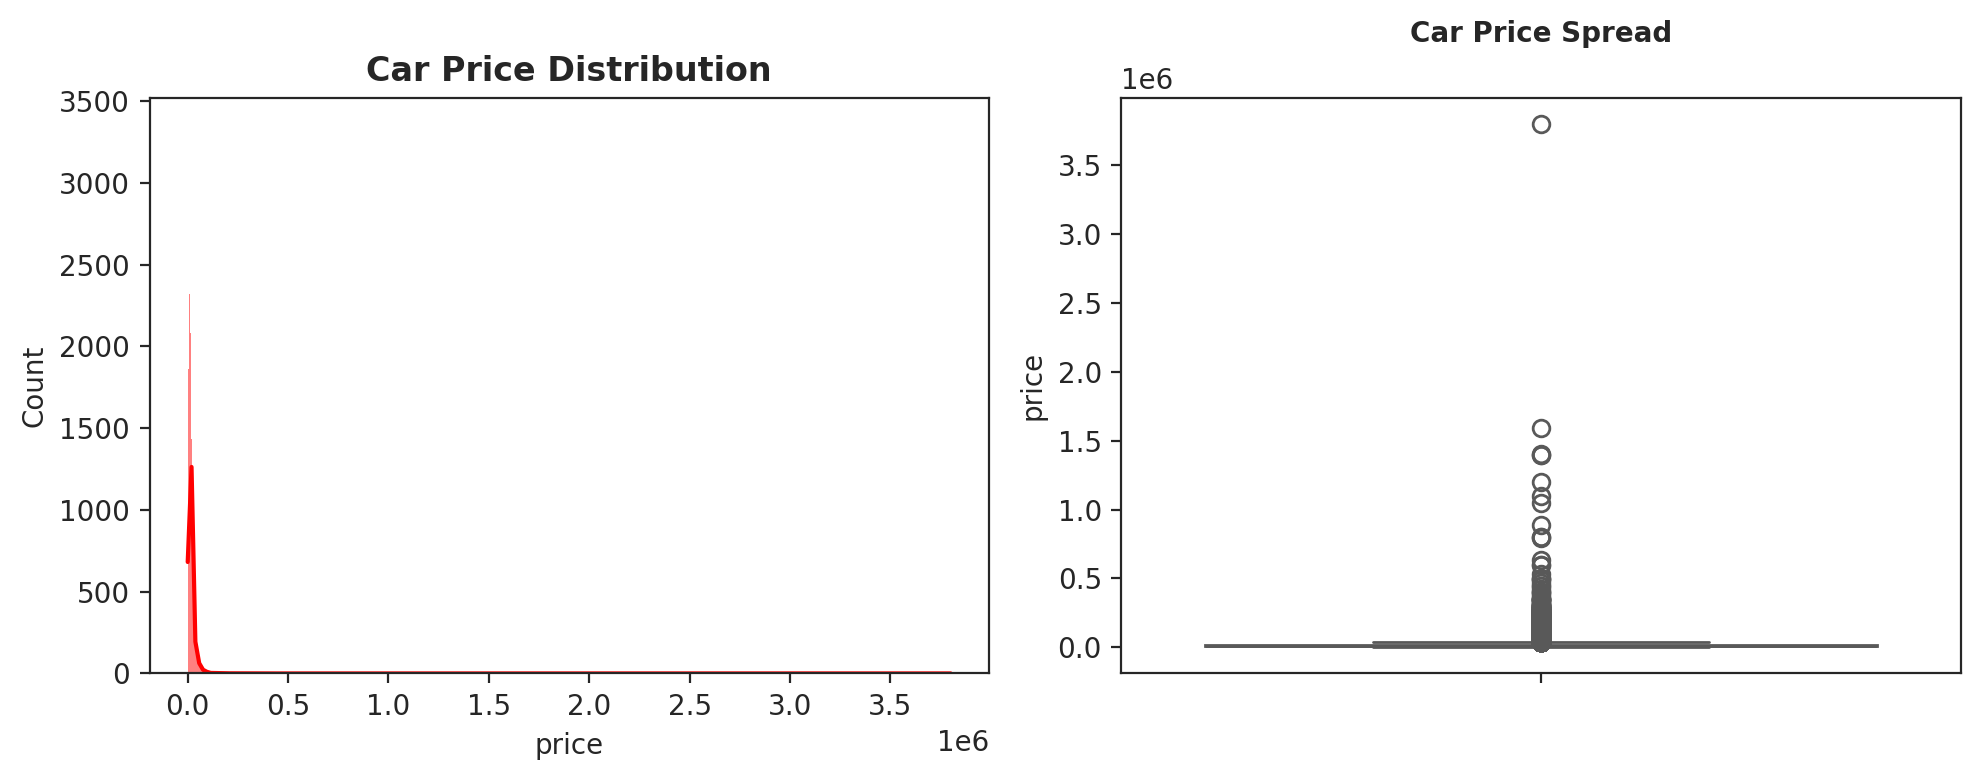

In [ ]:
plt.figure(figsize=(10, 4))

# Histogram for car price distribution
plt.subplot(1, 2, 1)
sns.histplot(new_data["price"], color="red", kde=True)
plt.title("Car Price Distribution", fontweight="bold")

# Boxplot for car price spread
plt.subplot(1, 2, 2)
sns.boxplot(y=new_data["price"], palette="Set2")
plt.title("Car Price Spread", fontweight="bold", pad=20, fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
new_data["price"].agg(["min","mean","median","max","std","skew"]).to_frame().T

,min,mean,median,max,std,skew
price,250.0,17165.277015,12500.0,3799995.0,26318.341486,46.631924


In [ ]:
# The data points are highly spread.

**Log Transformation of the Target Feature**

<ipython-input-29-50c165cc6e24>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=np.log(new_data["price"]), palette="Set2")


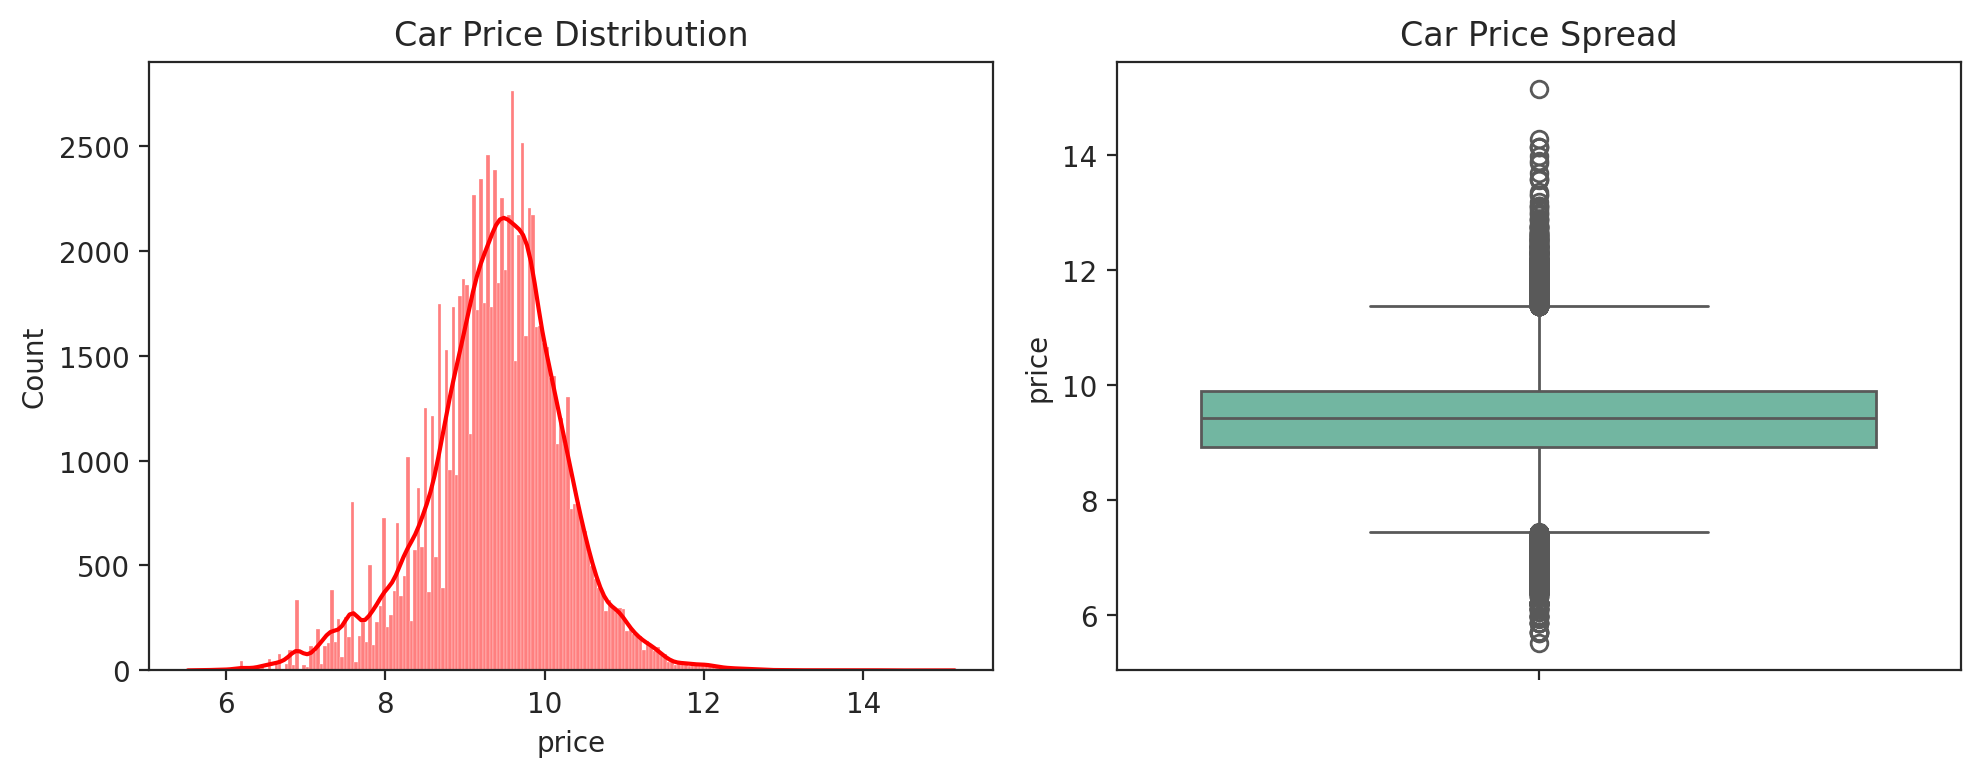

In [ ]:
plt.figure(figsize=(10, 4))

# Histogram for car price distribution
plt.subplot(1, 2, 1)
sns.histplot(np.log(new_data["price"]), color="red", kde=True)
plt.title("Car Price Distribution")

# Boxplot for car price spread
plt.subplot(1, 2, 2)
sns.boxplot(y=np.log(new_data["price"]), palette="Set2")
plt.title("Car Price Spread")

plt.tight_layout()
plt.show()

**Visualizing different type of car based on their Names**

Text(0, 0.5, 'Count of Cars')

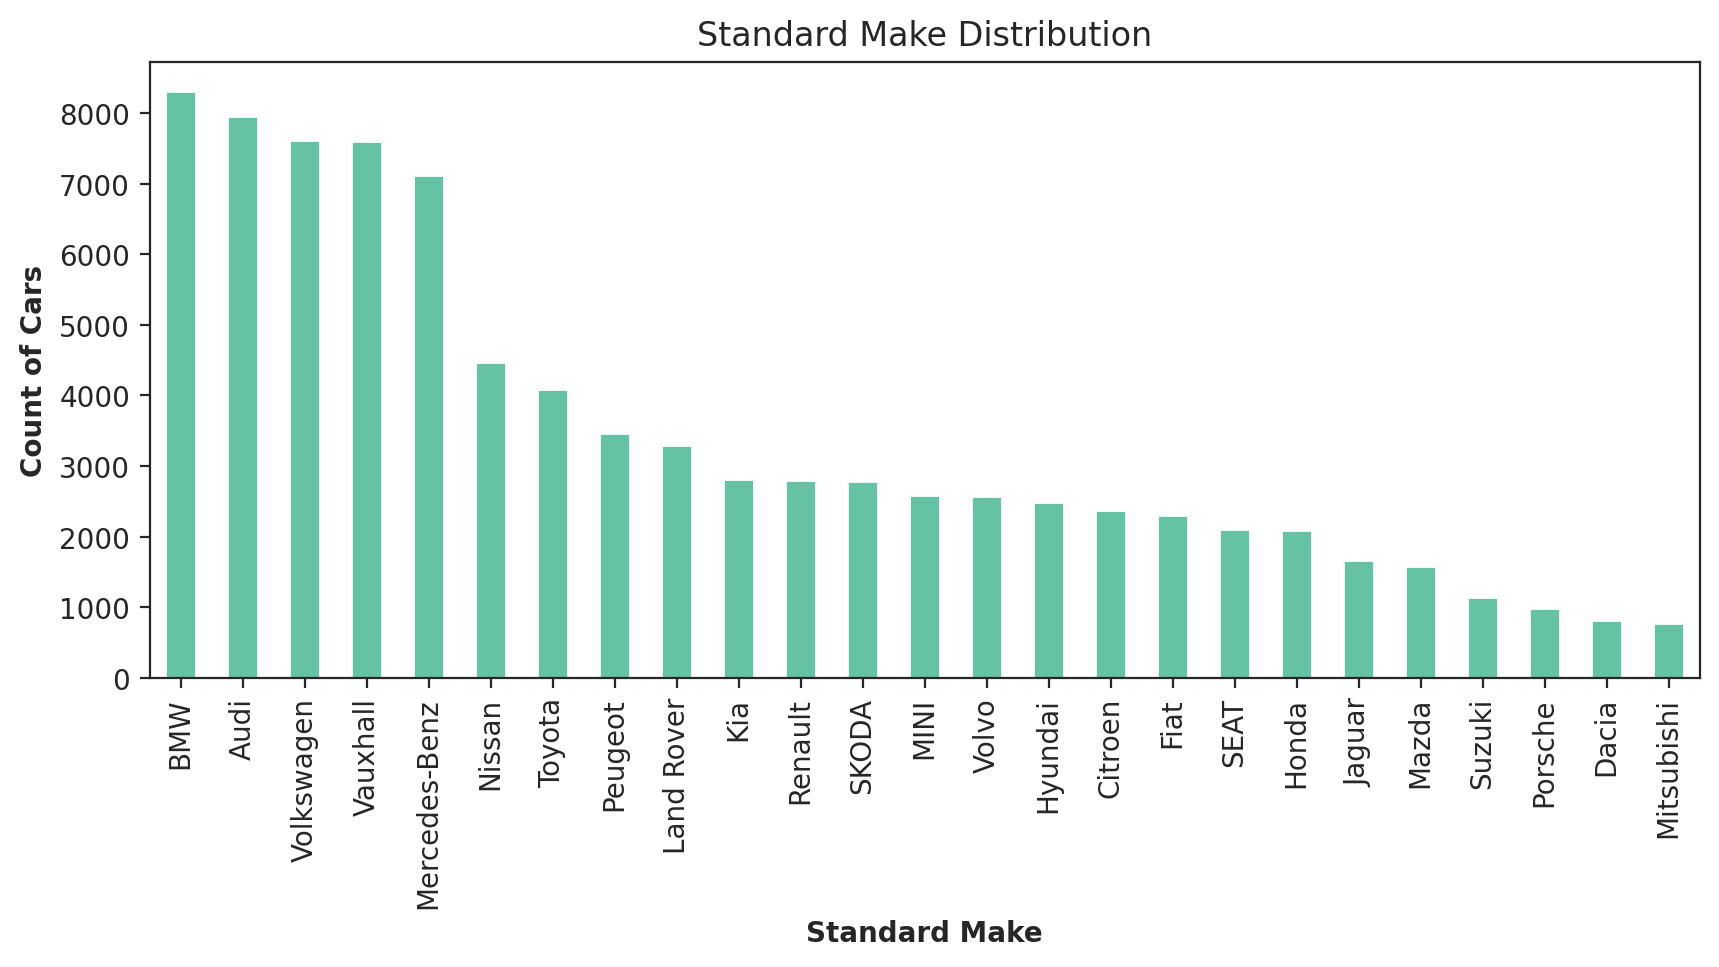

In [ ]:
# Visualizing the different car names available

plt.rcParams['figure.figsize'] = [10,4]
ax=new_data.standard_make.value_counts().head(25).plot(kind='bar',stacked=True, colormap = 'Set2')
ax.title.set_text('Standard Make Distribution')
plt.xlabel("Standard Make",fontweight = 'bold')
plt.ylabel("Count of Cars",fontweight = 'bold')

**Visualizing different type of car based on Fuel type**

Text(0, 0.5, 'Count of Cars')

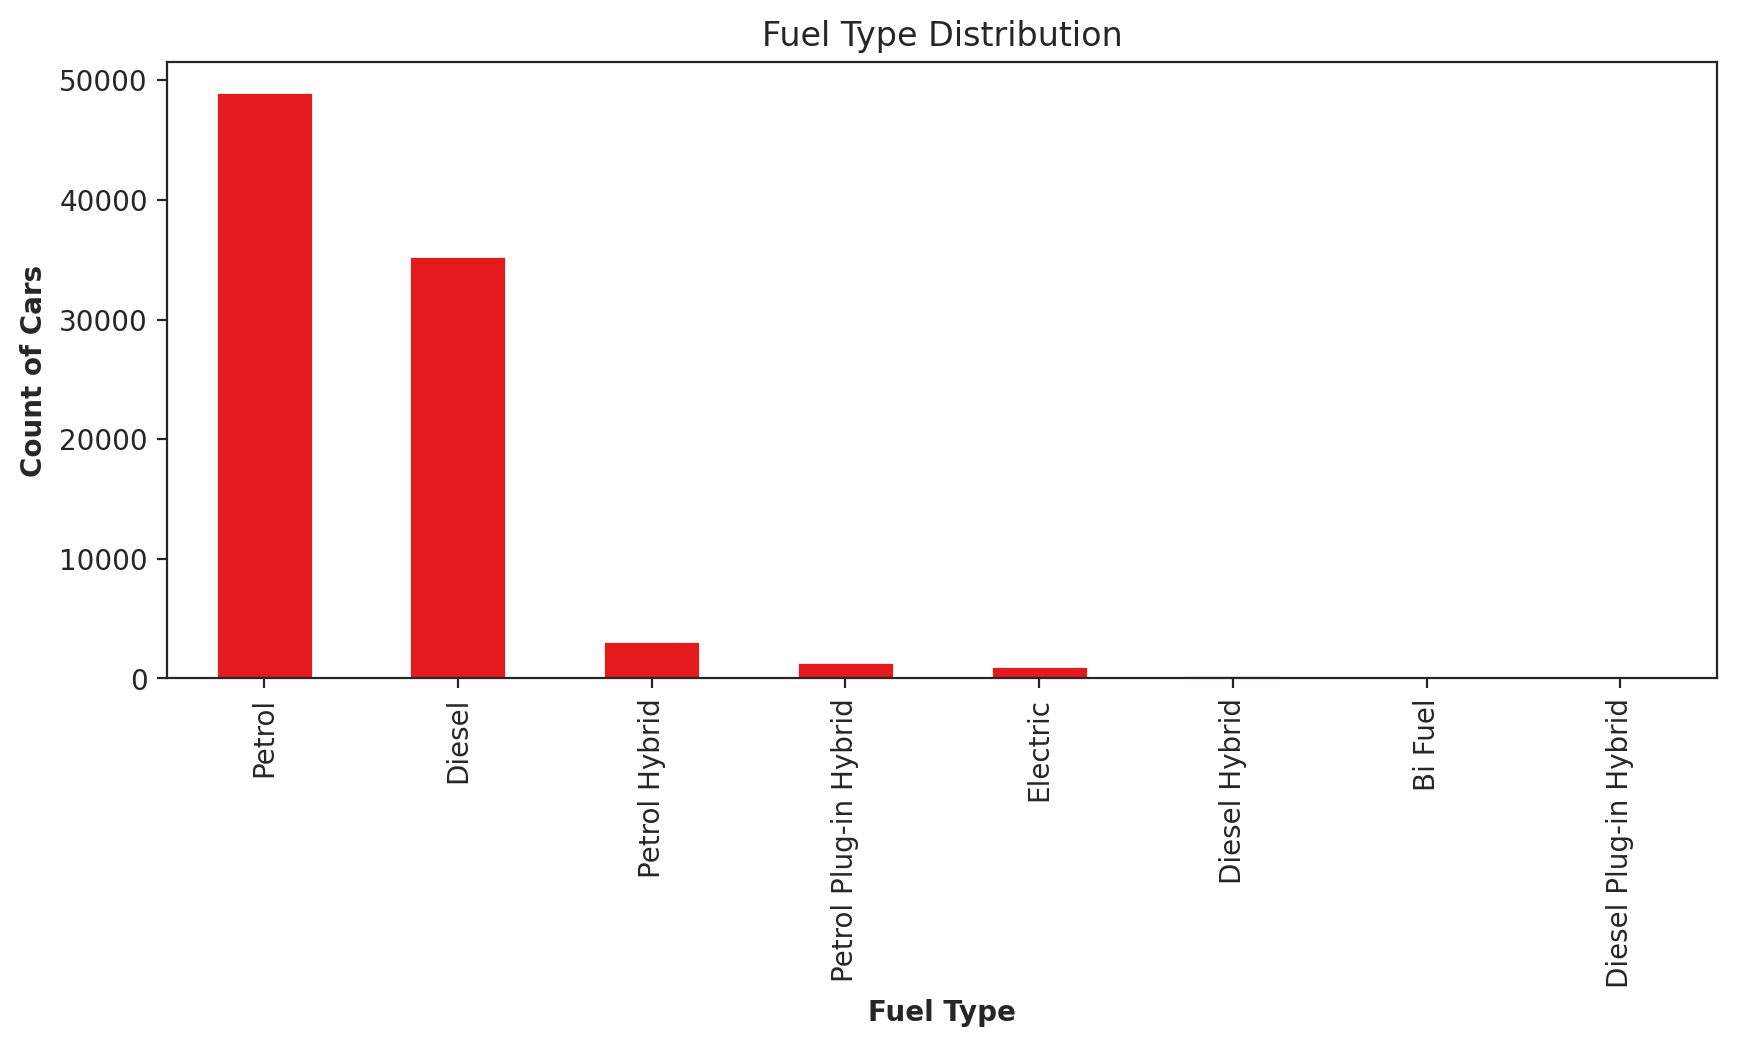

In [ ]:
plt.rcParams['figure.figsize'] = [10,4]
ax=new_data['fuel_type'].value_counts().plot(kind='bar',stacked=True, colormap = 'Set1')
ax.title.set_text('Fuel Type Distribution')
plt.xlabel("Fuel Type",fontweight = 'bold')
plt.ylabel("Count of Cars",fontweight = 'bold')

**Distribution of Vehicle Prices based on available fuel type**

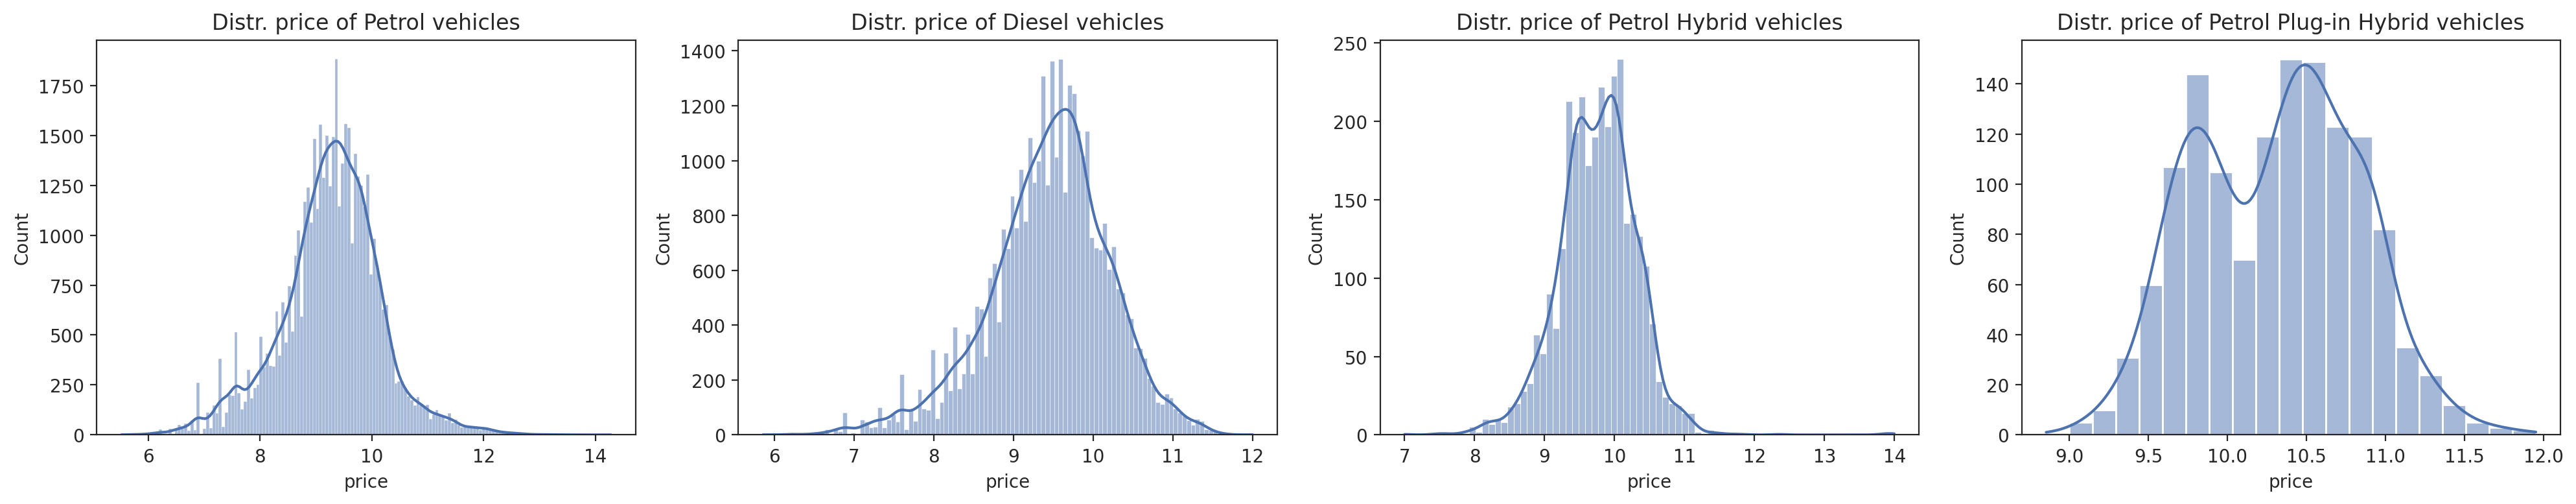

In [ ]:
fuelTypes = ["Petrol", "Diesel", "Petrol Hybrid", "Petrol Plug-in Hybrid"]

plt.figure(figsize=(20, 4))
for i, fuelType in enumerate(fuelTypes, 1):
    plt.subplot(140 + i)

    sns.histplot(np.log(new_data[new_data['fuel_type'] == fuelType]['price']), color='b', kde=True)
    plt.title(f'Distr. price of {fuelType} vehicles')

plt.tight_layout()
plt.show()

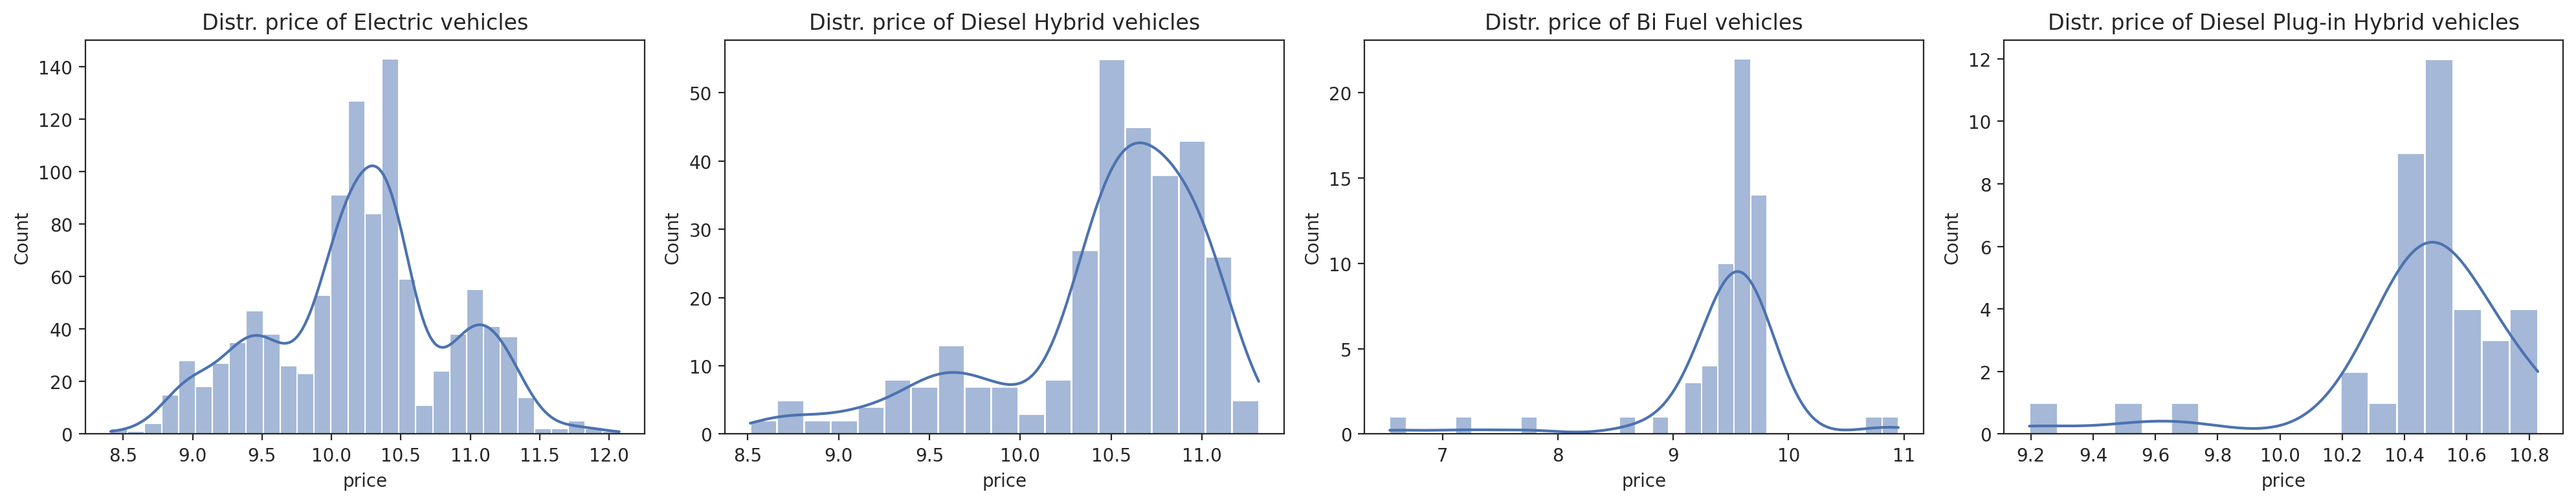

In [ ]:
fuelTypes = ["Electric", "Diesel Hybrid", "Bi Fuel", "Diesel Plug-in Hybrid"]

plt.figure(figsize=(20, 4))
for i, fuelType in enumerate(fuelTypes, 1):
    plt.subplot(140 + i)

    sns.histplot(np.log(new_data[new_data['fuel_type'] == fuelType]['price']), color='b', kde=True)
    plt.title(f'Distr. price of {fuelType} vehicles')

plt.tight_layout()
plt.show()

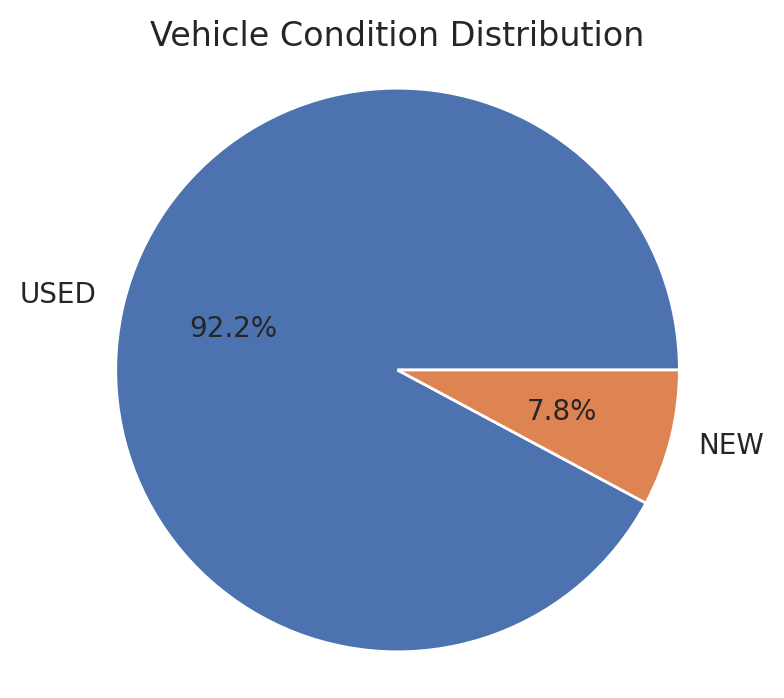

In [ ]:
plt.figure(figsize=(4,4))
plt.pie(new_data.vehicle_condition.value_counts(), labels=new_data.vehicle_condition.value_counts().index, autopct='%0.1f%%')
plt.title("Vehicle Condition Distribution")
plt.axis('equal')
plt.show()

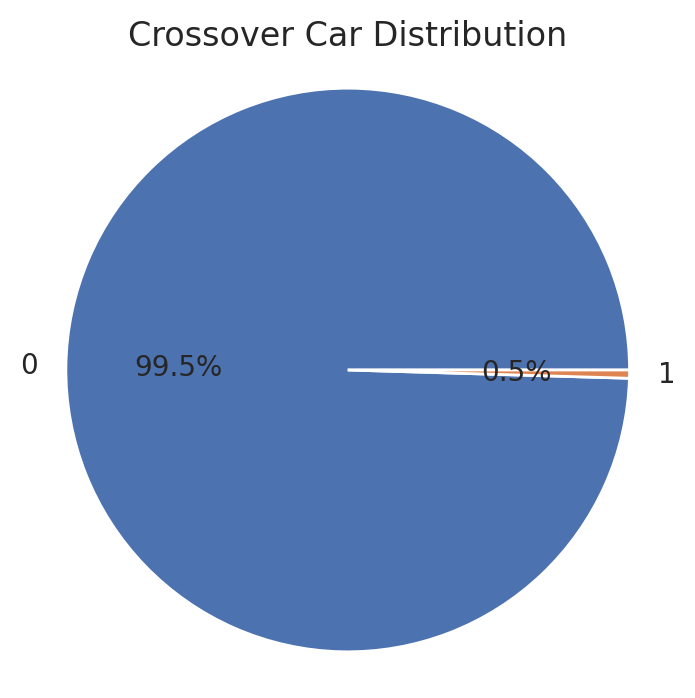

In [ ]:
plt.figure(figsize=(4,4))
plt.pie(new_data.crossover_car_and_van.value_counts(), labels=new_data.crossover_car_and_van.value_counts().index, autopct='%0.1f%%')
plt.title("Crossover Car Distribution")
plt.axis('equal')
plt.show()

Text(0, 0.5, 'Count of Cars')

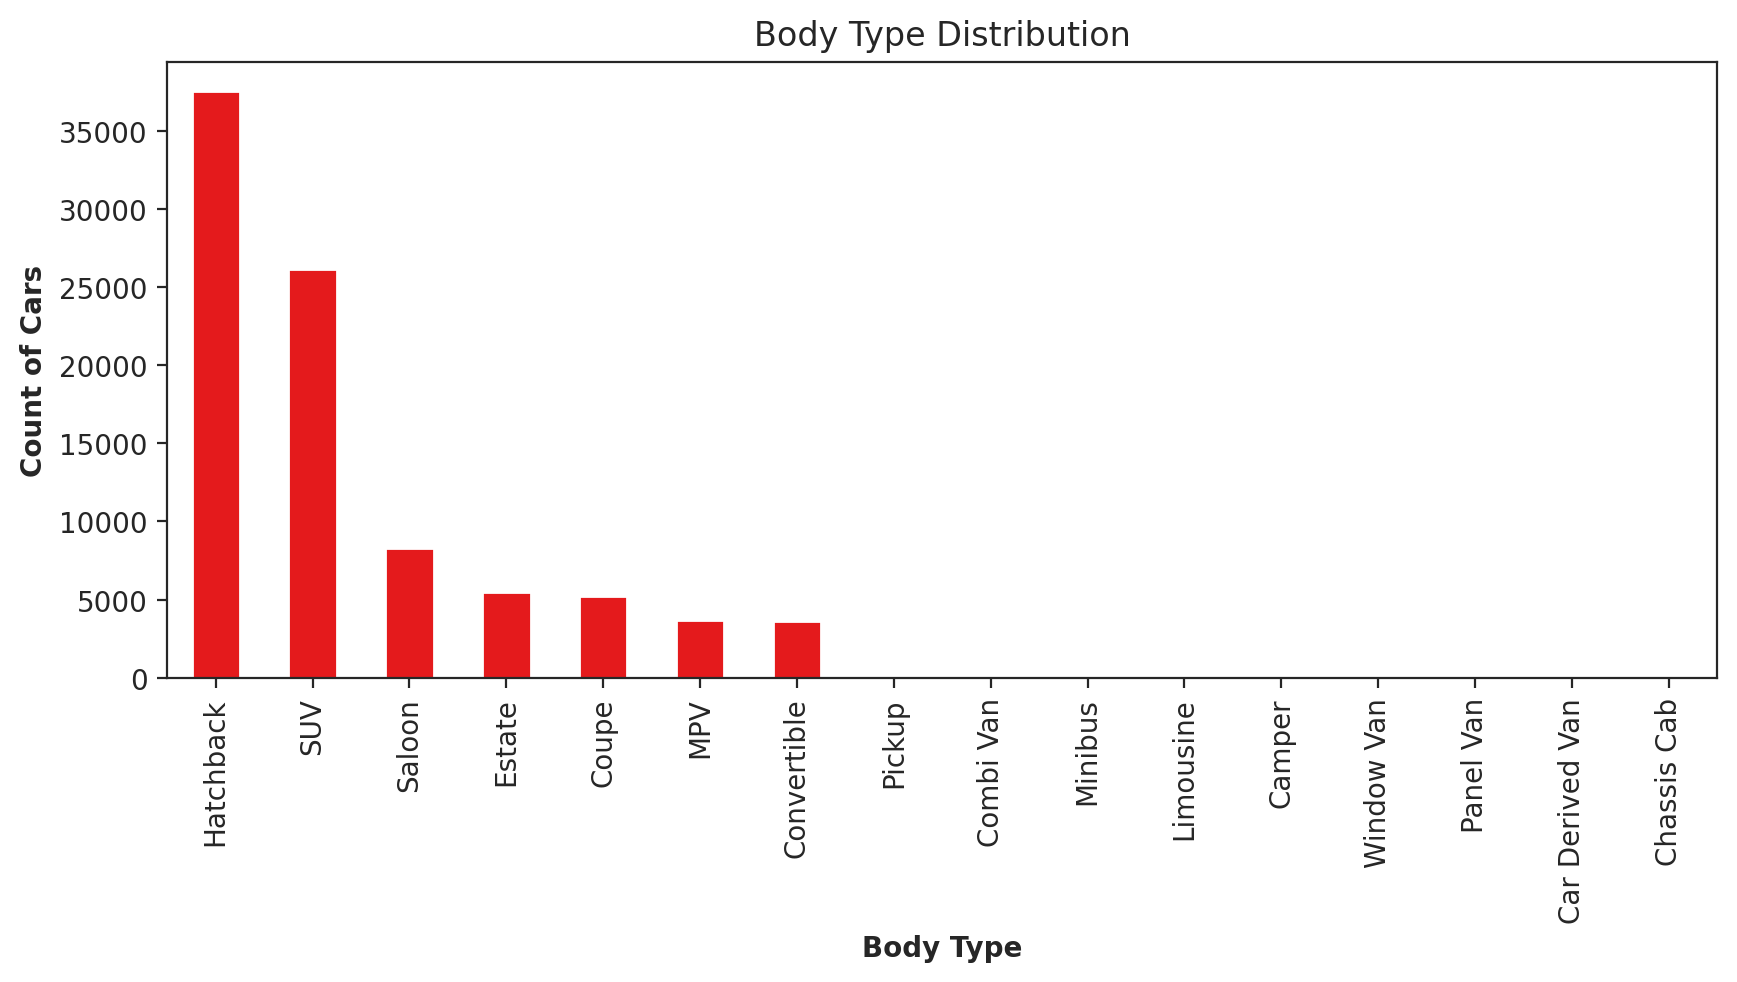

In [ ]:
plt.rcParams['figure.figsize'] = [10,4]
ax= new_data['body_type'].value_counts().plot(kind='bar',stacked=True, colormap = 'Set1')
ax.title.set_text('Body Type Distribution')
plt.xlabel("Body Type",fontweight = 'bold')
plt.ylabel("Count of Cars",fontweight = 'bold')

<Axes: xlabel='standard_colour', ylabel='price'>

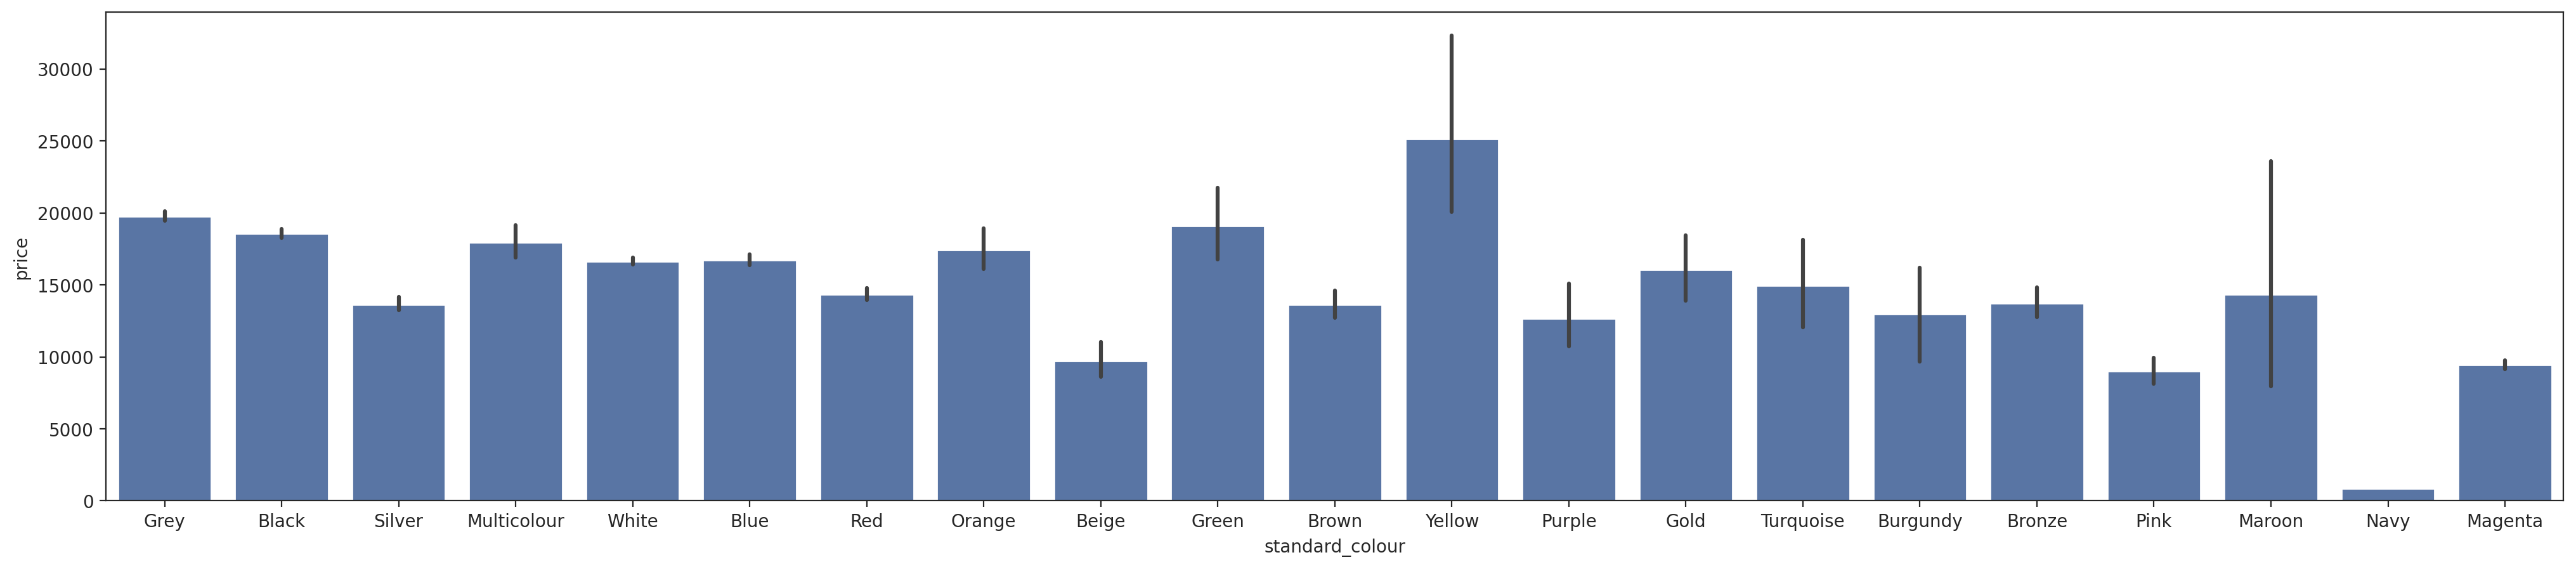

In [ ]:
plt.rcParams['figure.figsize'] = [25,5]
sns.barplot(x = 'standard_colour',
            y = 'price',
            data = new_data)

In [ ]:
new_data.groupby('standard_colour')[["price", "mileage"]].agg("mean", np.std).head()

,price,mileage
standard_colour,,
Beige,9721.351124,56665.671348
Black,18572.094666,40370.448235
Blue,16711.357526,37494.161665
Bronze,13713.000000,39157.007326
Brown,13617.787755,40224.728016


**Distribution of vehicle prices based on fuel type and vehicle condition**

<Axes: xlabel='fuel_type', ylabel='price'>

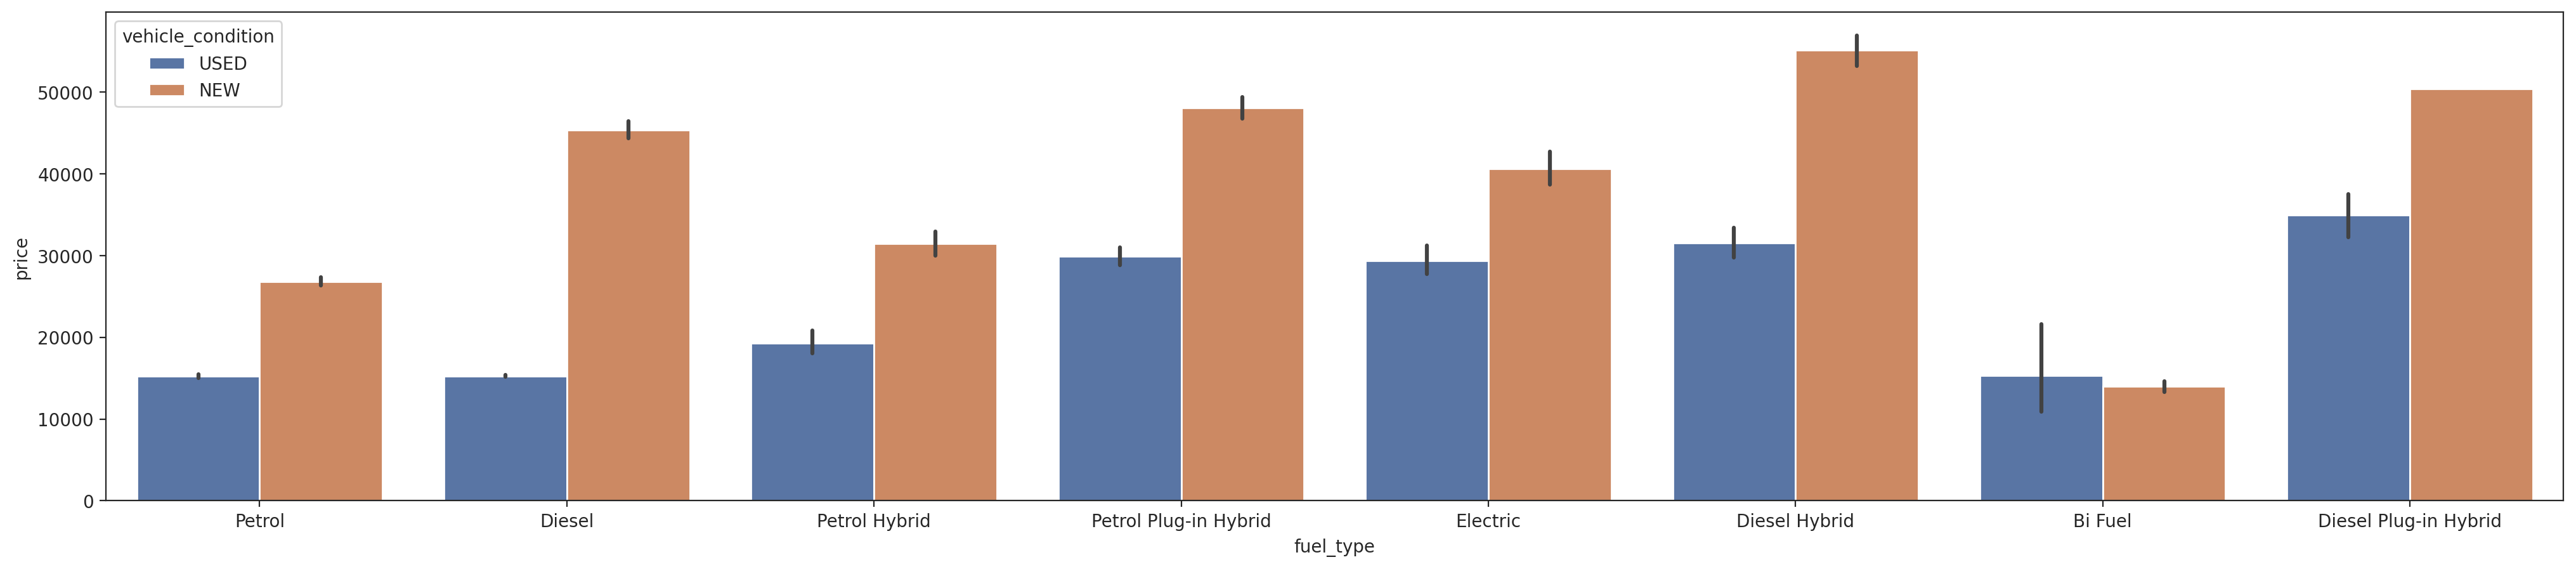

In [ ]:
plt.rcParams['figure.figsize'] = [25,5]
sns.barplot(x = 'fuel_type',
            y = 'price',
            hue = 'vehicle_condition',
            data = new_data)

**Vehicle Condition Feature**

In [ ]:
new_data.groupby('vehicle_condition')[["price", "mileage"]].agg("mean", np.std)

,price,mileage
vehicle_condition,,
NEW,32974.103658,5.396272
USED,15822.544087,40935.950272


<ipython-input-41-3ccd19189beb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'vehicle_condition', y = 'price', data = new_data, palette='colorblind')


<Axes: xlabel='vehicle_condition', ylabel='price'>

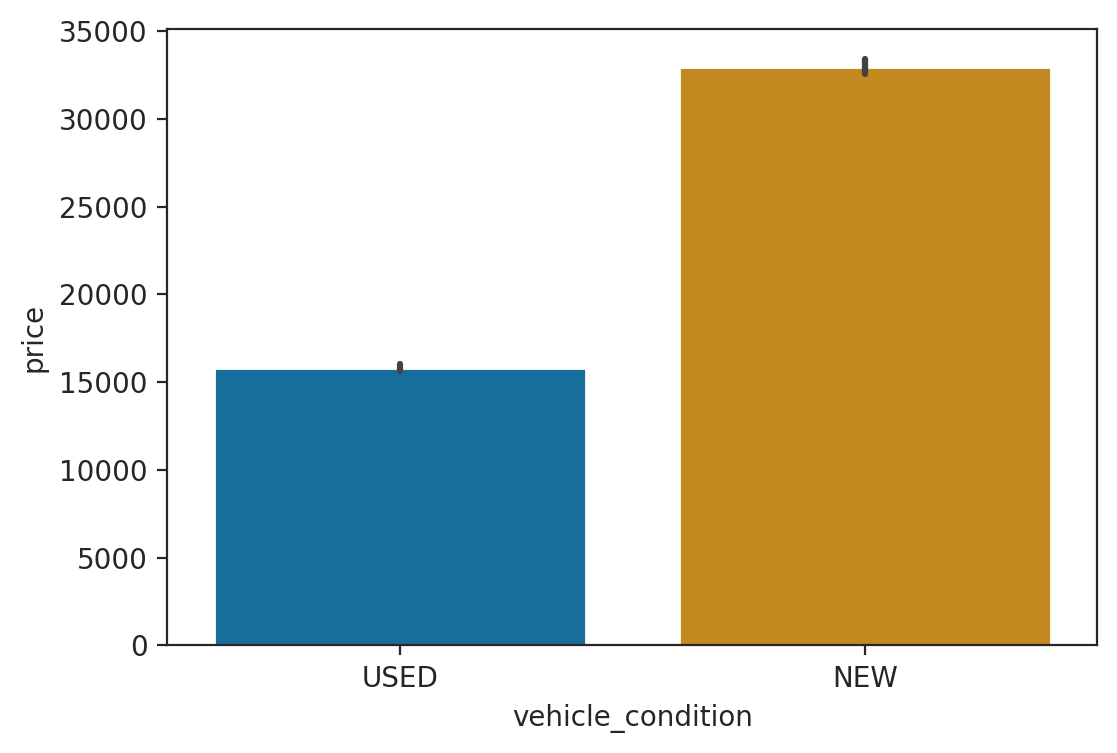

In [ ]:
plt.rcParams['figure.figsize'] = [6,4]
sns.barplot(x = 'vehicle_condition', y = 'price', data = new_data, palette='colorblind')

## **Feature Engineering**

In [ ]:
drop_cols = [
    "public_reference", "crossover_car_and_van","reg_code"
]
new_data = new_data.drop(drop_cols, axis = 1)

**Age Feature**

In [ ]:
# Getting the Age of vehicle from the year of registration
new_data["Age"] = 2024 - new_data['year_of_registration']

Text(0.5, 0, 'Age')

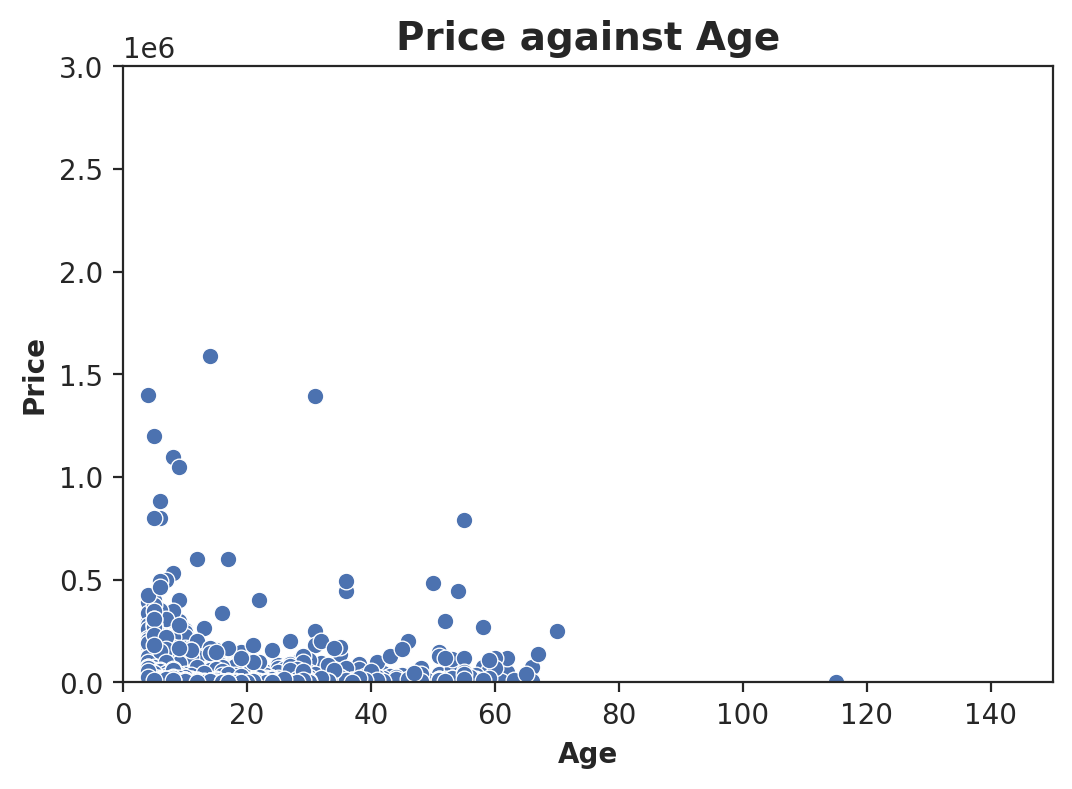

In [ ]:
sns.scatterplot(x="Age", y="price", data=new_data, color='b')
plt.xlim([0, 150])
plt.ylim([0, 3000000])
plt.title("Price against Age", fontsize=14, fontweight='bold')
plt.ylabel("Price", fontweight='bold')
plt.xlabel("Age", fontweight='bold')

Text(0.5, 1.0, 'Age Outliers Variable Distribution')

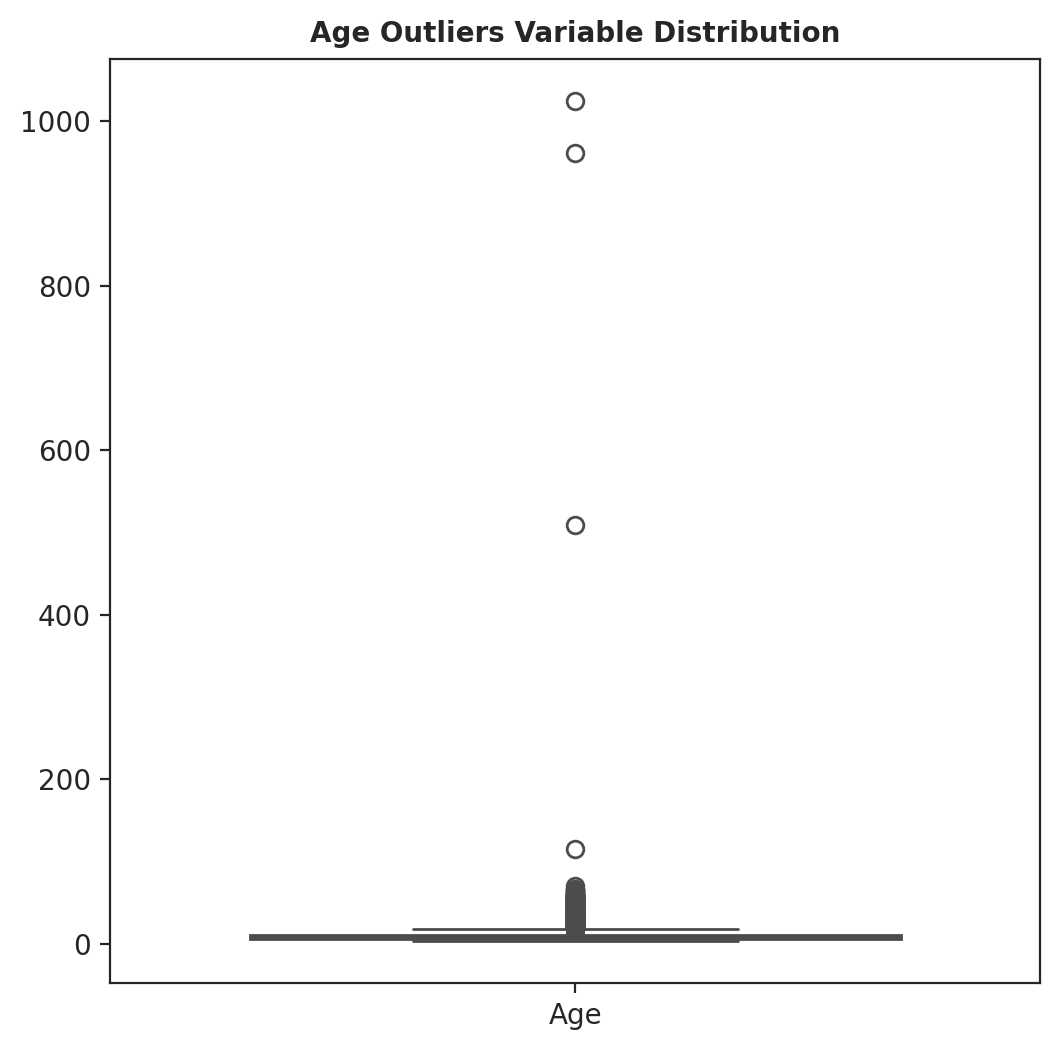

In [ ]:
outliers = ['Age']
plt.rcParams['figure.figsize'] = [6,6]
sns.boxplot(data= new_data[outliers], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Age Outliers Variable Distribution", fontsize = 10, fontweight = 'bold')

In [ ]:
# Assuming Age is normally distributed
# Calculate the lower and upper boundary using IQR

upper_boundary = new_data['Age'].mean() + 3*new_data['Age'].std()
lower_boundary = new_data['Age'].mean() - 3*new_data['Age'].std()

new_data['Age'] = np.where(new_data['Age']>upper_boundary, upper_boundary,new_data['Age'])

Text(0.5, 1.0, 'Outliers Variable Distribution')

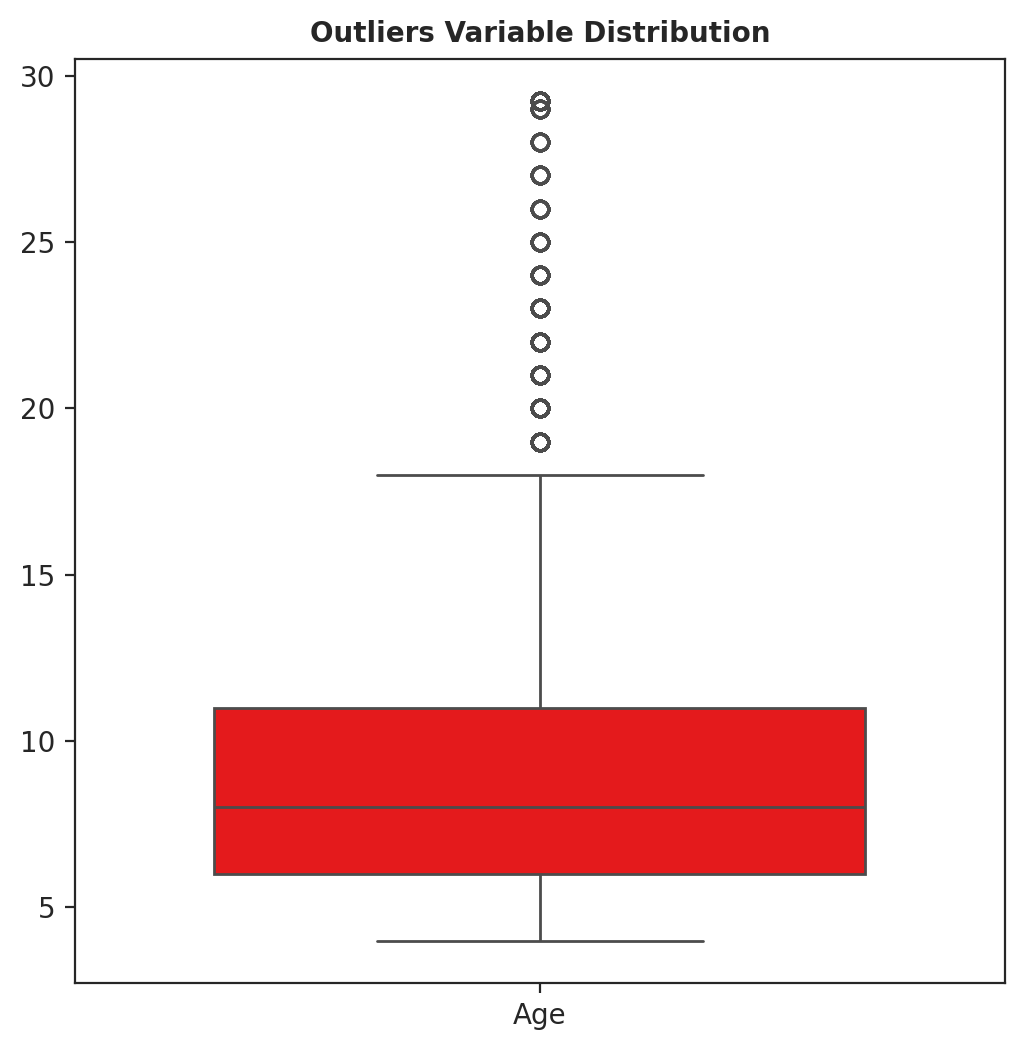

In [ ]:
# Outlier Analysis of target variable with maximum amount of Inconsistency

outliers = ['Age']
plt.rcParams['figure.figsize'] = [6,6]
sns.boxplot(data= new_data[outliers], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 10, fontweight = 'bold')

**Feature Interaction**

In [ ]:
new_data["fuelType_vehicleCond"] = new_data["fuel_type"].astype(str) + "_"  + new_data["vehicle_condition"].astype(str)

In [ ]:
new_data["bodyType_stdColor"] = new_data["body_type"].astype(str) + "_"  + new_data["standard_colour"].astype(str)

In [ ]:
new_data["stdMake_stdModel"] = new_data["standard_make"].astype(str) + "_"  + new_data["standard_model"].astype(str)

In [ ]:
new_data["stdMake_stdColor"] = new_data["standard_make"].astype(str) + "_"  + new_data["standard_colour"].astype(str)

In [ ]:
new_data.head()

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,fuel_type,Age,fuelType_vehicleCond,bodyType_stdColor,stdMake_stdModel,stdMake_stdColor
19845,43126.0,Grey,Hyundai,ix20,USED,2013.0,5936,Hatchback,Petrol,11.0,Petrol_USED,Hatchback_Grey,Hyundai_ix20,Hyundai_Grey
92032,32966.0,Black,Mercedes-Benz,GLC Class,USED,2017.0,21990,SUV,Diesel,7.0,Diesel_USED,SUV_Black,Mercedes-Benz_GLC Class,Mercedes-Benz_Black
360322,52405.0,Silver,Mercedes-Benz,C Class,USED,2017.0,13500,Saloon,Diesel,7.0,Diesel_USED,Saloon_Silver,Mercedes-Benz_C Class,Mercedes-Benz_Silver
150970,35195.0,Black,BMW,3 Series,USED,2017.0,13000,Saloon,Diesel,7.0,Diesel_USED,Saloon_Black,BMW_3 Series,BMW_Black
114145,89000.0,Black,Vauxhall,Corsa,USED,2013.0,2995,Hatchback,Petrol,11.0,Petrol_USED,Hatchback_Black,Vauxhall_Corsa,Vauxhall_Black


## **Data Splitting**

In [ ]:
y = new_data['price']
X = new_data.drop(['price', 'year_of_registration'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=23
)

# **Pre-Processing with Feature Selection**

In [ ]:
from sklearn.feature_selection import RFECV

In [ ]:
def create_pp_ppln(X, linear_model=False):
    # Define numeric features
    numeric_features = X.select_dtypes(exclude='object').columns.tolist()

    # Define preprocessing steps for numeric features
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean"))
        ]
    )
    if linear_model:
        numeric_transformer.steps.extend([
            ("scaler", StandardScaler()),
            ('poly', PolynomialFeatures(include_bias=False))
        ])

    # Define categorical features
    categorical_features = X.select_dtypes(include='object').columns.tolist()

    # Define preprocessing steps for categorical features
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("te", TargetEncoder(handle_unknown="value", handle_missing="return_nan")),
        ]
    )

    # Create ColumnTransformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    # Feature Selection
    feature_selector = RFECV(estimator=LinearRegression(), step=1, cv=5)

    # Preprocessor with feature selection
    pp_with_selection = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("feature_selection", feature_selector)
        ]
    )

    return pp_with_selection

In [ ]:
def create_regr_ppln(est, X, linear_model=False):
    # Create regression pipeline with preprocessing and estimator
    regr_pipe = Pipeline(
        steps=[
            ("pp", create_pp_ppln(X, linear_model)),
            ("regr", est)
        ]
    )

    return regr_pipe

## **Model Fitting**

In [ ]:
gbr = create_regr_ppln(GradientBoostingRegressor(max_depth=3), X_train)
rfr = create_regr_ppln(RandomForestRegressor(max_depth=8), X_train)
lr = create_regr_ppln(LinearRegression(), X_train, linear_model=True)
my_models = [gbr, rfr, lr]

In [ ]:
model_results_list = []
for my_model in my_models:
    eval_results = cross_validate(
        my_model, X, y, cv=5,
        scoring='neg_mean_absolute_error',
        return_train_score=True
    )
    model_results_list.append(
        (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
         -eval_results['train_score'].mean(), eval_results['train_score'].std())
    )

In [ ]:
model_results = pd.DataFrame(
    model_results_list,
    columns=['test_mae_mean', 'test_mae_std', 'train_mae_mean', 'train_mae_std'],
    index=['gbr', 'rfr', 'lr']
)

In [ ]:
model_results

,test_mae_mean,test_mae_std,train_mae_mean,train_mae_std
gbr,3477.999634,77.679878,3274.039206,16.398902
rfr,3449.853606,92.061212,3201.717906,60.513883
lr,5711.318588,185.835575,5643.840588,227.892824


In [ ]:
for est in my_models:
    est.fit(X_train, y_train)

In [ ]:
ensemble = VotingRegressor(
    [
        ("gb", gbr),
        ("rf", rfr),
        ('lr', lr)
    ]
)
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('gb',
                             Pipeline(steps=[('pp',
                                              Pipeline(steps=[('preprocessor',
                                                               ColumnTransformer(remainder='passthrough',
                                                                                 transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer())]),
                                                                                                ['mileage',
                                                                                                 'Age']),
                                                                                               ('cat',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                                ('te',
                                                                                                                 TargetEncoder(handle_missing='return_nan'))]),
                                                                                                ['stand...
                                                                                                                 TargetEncoder(handle_missing='return_nan'))]),
                                                                                                ['standard_colour',
                                                                                                 'standard_make',
                                                                                                 'standard_model',
                                                                                                 'vehicle_condition',
                                                                                                 'body_type',
                                                                                                 'fuel_type',
                                                                                                 'fuelType_vehicleCond',
                                                                                                 'bodyType_stdColor',
                                                                                                 'stdMake_stdModel',
                                                                                                 'stdMake_stdColor'])],
                                                                                 verbose_feature_names_out=False)),
                                                              ('feature_selection',
                                                               RFECV(cv=5,
                                                                     estimator=LinearRegression()))])),
                                             ('regr', LinearRegression())]))])

In [ ]:
eval_results = cross_validate(
    ensemble, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
ensemble_result = (
    -eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std()
)

In [ ]:
model_results.loc['ensemble'] = ensemble_result

In [ ]:
model_results

,test_mae_mean,test_mae_std,train_mae_mean,train_mae_std
gbr,3477.999634,77.679878,3274.039206,16.398902
rfr,3449.853606,92.061212,3201.717906,60.513883
lr,5711.318588,185.835575,5643.840588,227.892824
ensemble,3803.778161,46.066452,3637.567642,73.569664


# **Evaluation Comparison**

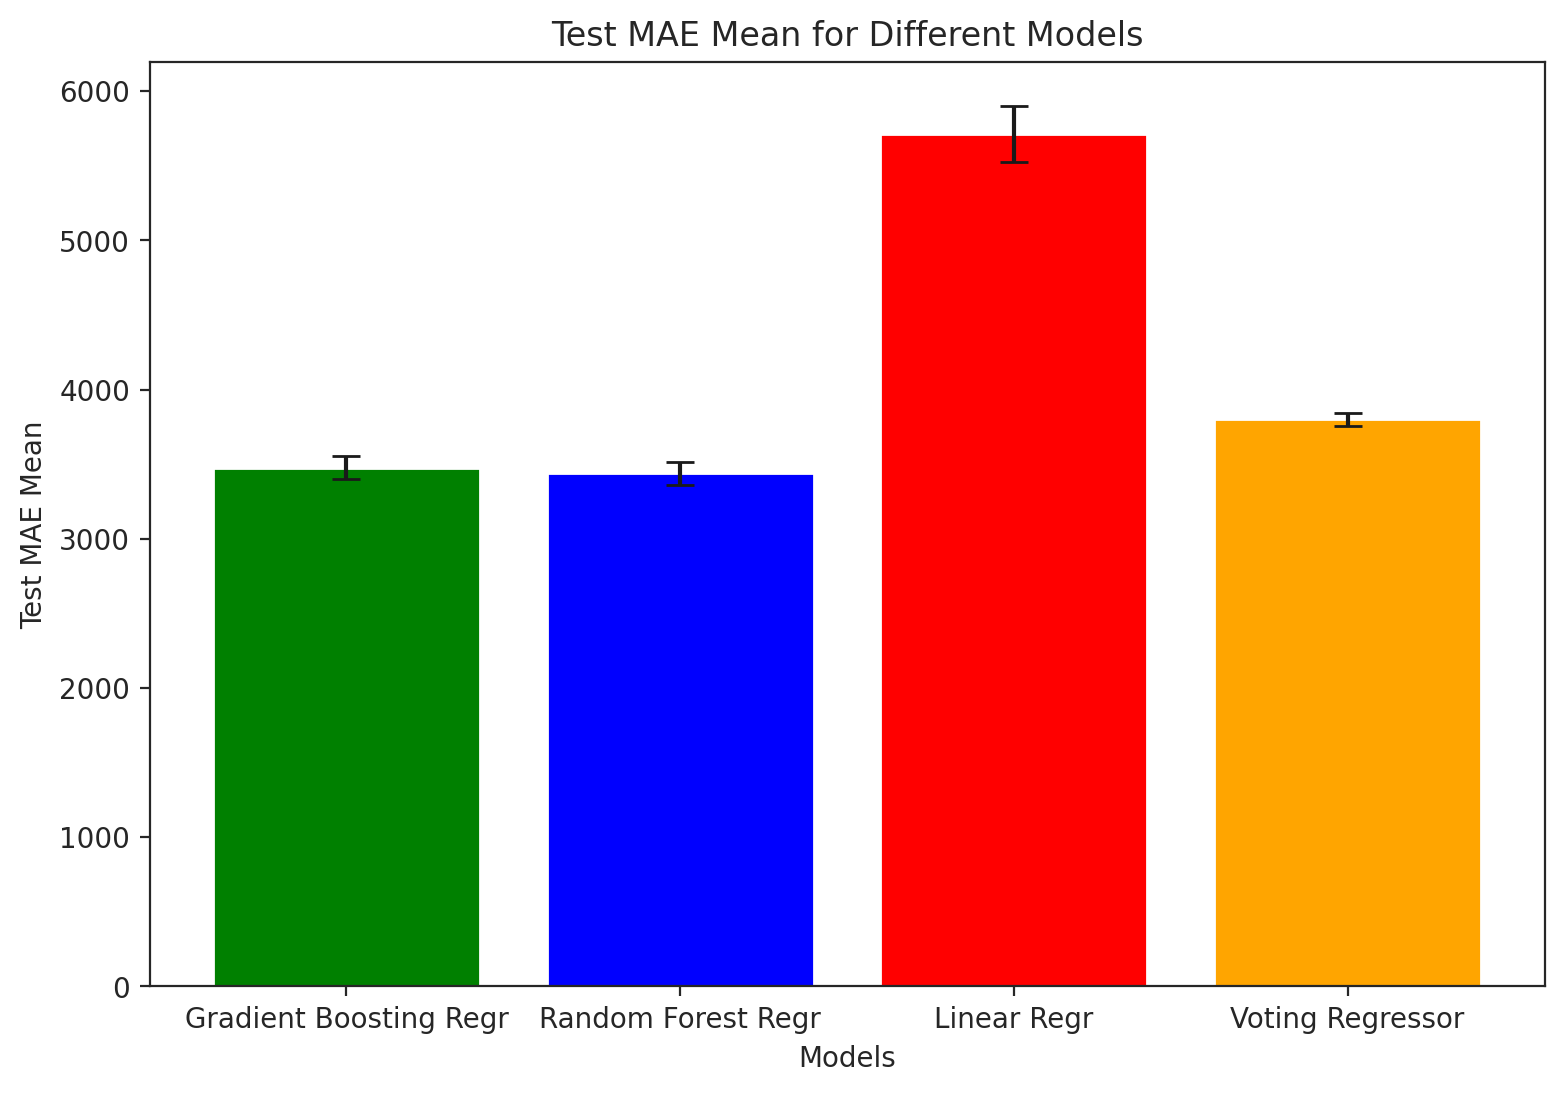

In [ ]:
# Model results data
model_results_data = {
    'Model': ['Gradient Boosting Regr', 'Random Forest Regr', 'Linear Regr', 'Voting Regressor'],
    'Test MAE Mean': [3477.453248, 3439.697733, 5711.318588, 3801.411930],
    'Test MAE Std': [77.707094, 77.042130, 185.835575, 44.154378]
}

# Convert data to DataFrame
model_results = pd.DataFrame(model_results_data)

# Define colors for each bar
colors = ['green', 'blue', 'red', 'orange']

# Plotting
plt.figure(figsize=(9, 6))
plt.bar(model_results['Model'], model_results['Test MAE Mean'], yerr=model_results['Test MAE Std'], capsize=5, color=colors)
plt.xlabel('Models')
plt.ylabel('Test MAE Mean')
plt.title('Test MAE Mean for Different Models')
plt.show()

## **True vs Predicted Analysis (Gradient Boosting Regressor)**

In [ ]:
# Get the first model from the list (Gradient Boosting Regressor)
estimator = my_models[0]

In [ ]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer())]),
                                                                   ['mileage',
                                                                    'Age']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('te',
                                                                                    TargetEncoder(handle_missing='return_nan'))]),
                                                                   ['standard_colour',
                                                                    'standard_make',
                                                                    'standard_model',
                                                                    'vehicle_condition',
                                                                    'body_type',
                                                                    'fuel_type',
                                                                    'fuelType_vehicleCond',
                                                                    'bodyType_stdColor',
                                                                    'stdMake_stdModel',
                                                                    'stdMake_stdColor'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  RFECV(cv=5, estimator=LinearRegression()))])),
                ('regr', GradientBoostingRegressor())])

In [ ]:
prediction_gbr =  estimator.predict(X_test)

In [ ]:
eval = pd.DataFrame()
eval["True Price"] = y_test
eval["Predicted Price"] = prediction_gbr

In [ ]:
eval.head()

,True Price,Predicted Price
119188,7475,8686.560632
301456,23990,23895.777147
106393,2900,7928.545143
320391,9495,10502.990485
81908,5999,17447.448480


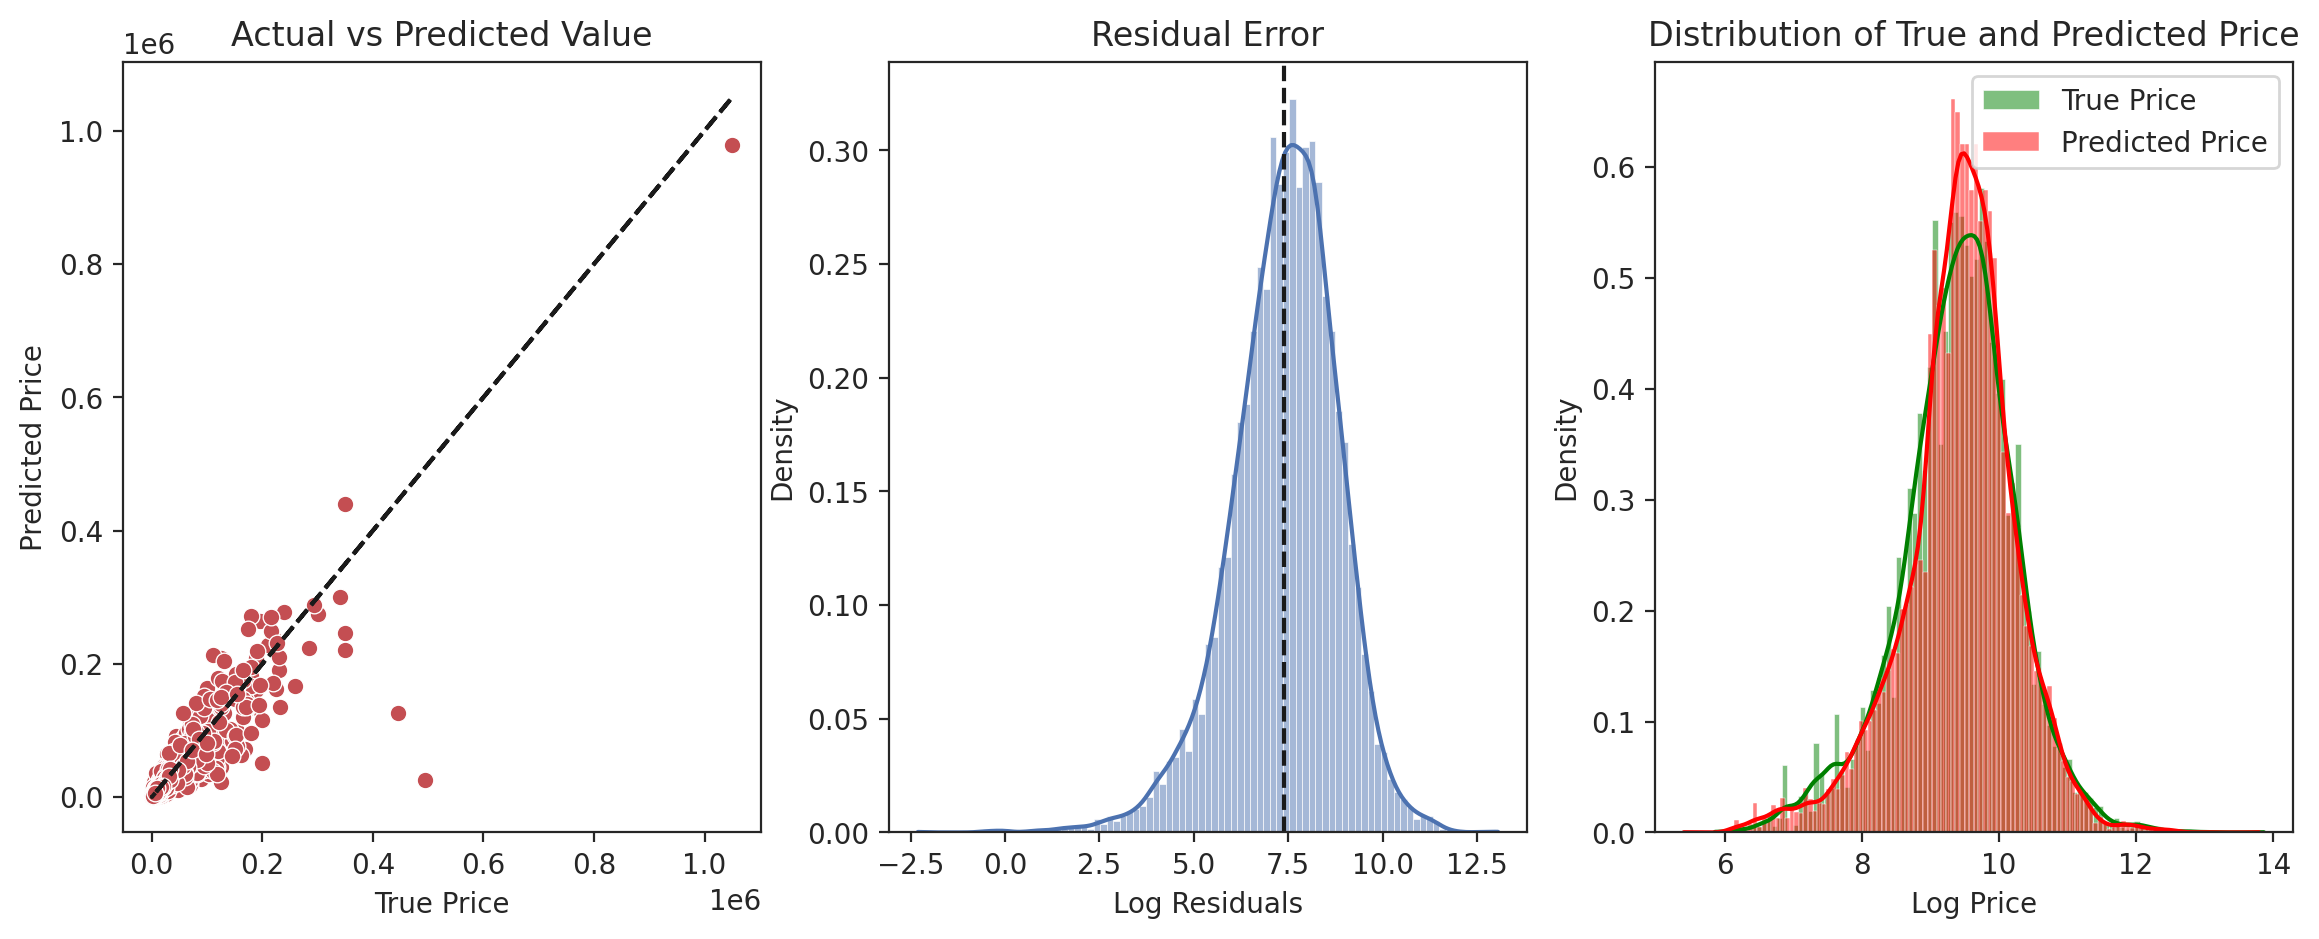

In [ ]:
# Check for Linearity
plt.figure(figsize=(14, 5))

plt.subplot(131)
sns.scatterplot(x="True Price", y="Predicted Price", data=eval, color='r')
plt.plot(eval["True Price"], eval["True Price"], color='k', linestyle='--')
plt.title('Actual vs Predicted Value')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

# Check for Residual normality & mean
plt.subplot(132)
residuals = y_test - prediction_gbr
residuals = residuals[residuals > 0]  # Filter out negative or zero residuals
sns.histplot(np.log(residuals), color='b', kde=True, stat='density')
plt.axvline(np.log(residuals).mean(), color='k', linestyle='--')
plt.title('Residual Error')
plt.xlabel('Log Residuals')

# Distribution of True and Predicted Price
plt.subplot(133)
true_prices = eval["True Price"]
predicted_prices = eval["Predicted Price"]
true_prices = true_prices[true_prices > 0]  # Filter out negative or zero true prices
predicted_prices = predicted_prices[predicted_prices > 0]  # Filter out negative or zero predicted prices
sns.histplot(np.log(true_prices), color='green', label='True Price', kde=True, stat='density')  # Change count to density
sns.histplot(np.log(predicted_prices), color='red', label='Predicted Price', kde=True, stat='density')  # Change count to density
plt.title('Distribution of True and Predicted Price')
plt.xlabel('Log Price')
plt.legend()

plt.show()

## **Global and Local Explanations with SHAP**

In [ ]:
def plot_est_feat_imp_barh(est, feat_names, ax=None, top_feat_k=10, style_kws={}):
    """ """
    if ax is None:
        fig, ax = plt.subplots()

    return pd.Series(
        est.feature_importances_,
        index=feat_names
    ).sort_values().tail(top_feat_k).plot.barh(**style_kws)

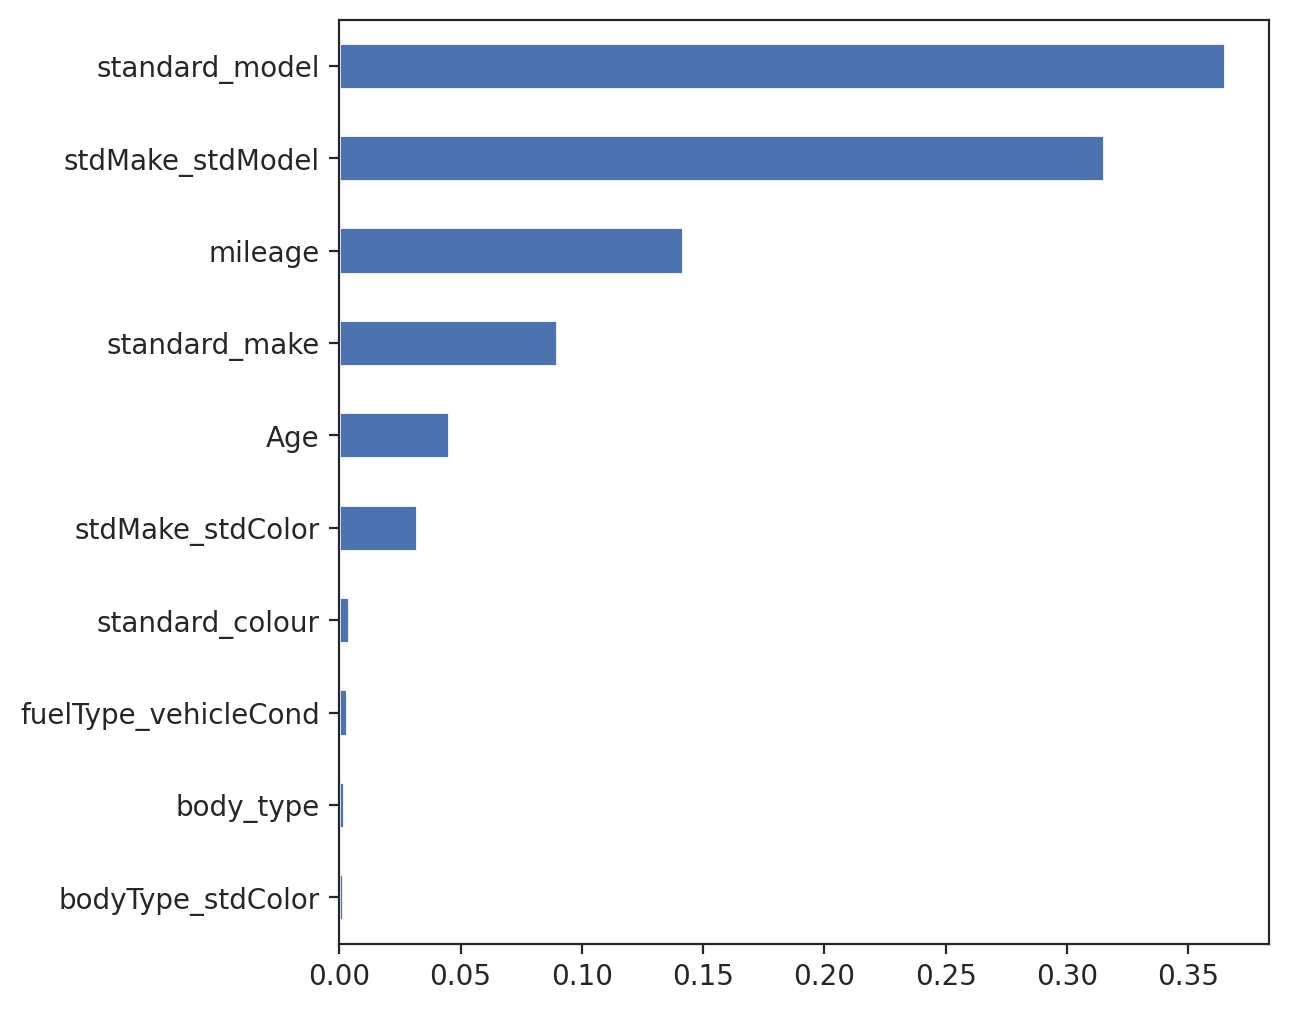

In [ ]:
plot_est_feat_imp_barh(estimator['regr'], estimator['pp'].get_feature_names_out());

**SHAP Explainer and Local Explanations**

In [ ]:
X_train_pp = estimator['pp'].transform(X_train)
column_names = X_train_pp.columns
X_test_pp  = estimator['pp'].transform(X_test)

In [ ]:
subset_size = 3050

X_train_subset = X_train_pp.head(subset_size)
X_test_subset = X_test_pp.head(subset_size)

In [ ]:
explainer = shap.Explainer(estimator['regr'], X_train_pp)

In [ ]:
explainer

In [ ]:
X_train_pp.head(1)

,mileage,Age,standard_colour,standard_make,standard_model,body_type,fuel_type,fuelType_vehicleCond,bodyType_stdColor,stdMake_stdModel,stdMake_stdColor
1031,38043.0,7.0,16559.004923,11326.515642,17079.105668,10759.135791,33417.946108,29639.729779,11201.064605,17079.105668,12140.341924


In [ ]:
X_test_pp.head(1)

,mileage,Age,standard_colour,standard_make,standard_model,body_type,fuel_type,fuelType_vehicleCond,bodyType_stdColor,stdMake_stdModel,stdMake_stdColor
119188,96000.0,13.0,14420.949636,20567.77198,18735.707269,33030.401928,16478.745997,15252.505667,42714.873418,18735.707269,16630.143552


In [ ]:
explanations = explainer(X_train_pp
                         , check_additivity=False)

100%|===================| 72192/72360 [01:10<00:00]       

In [ ]:
explanations.shape

(72360, 11)

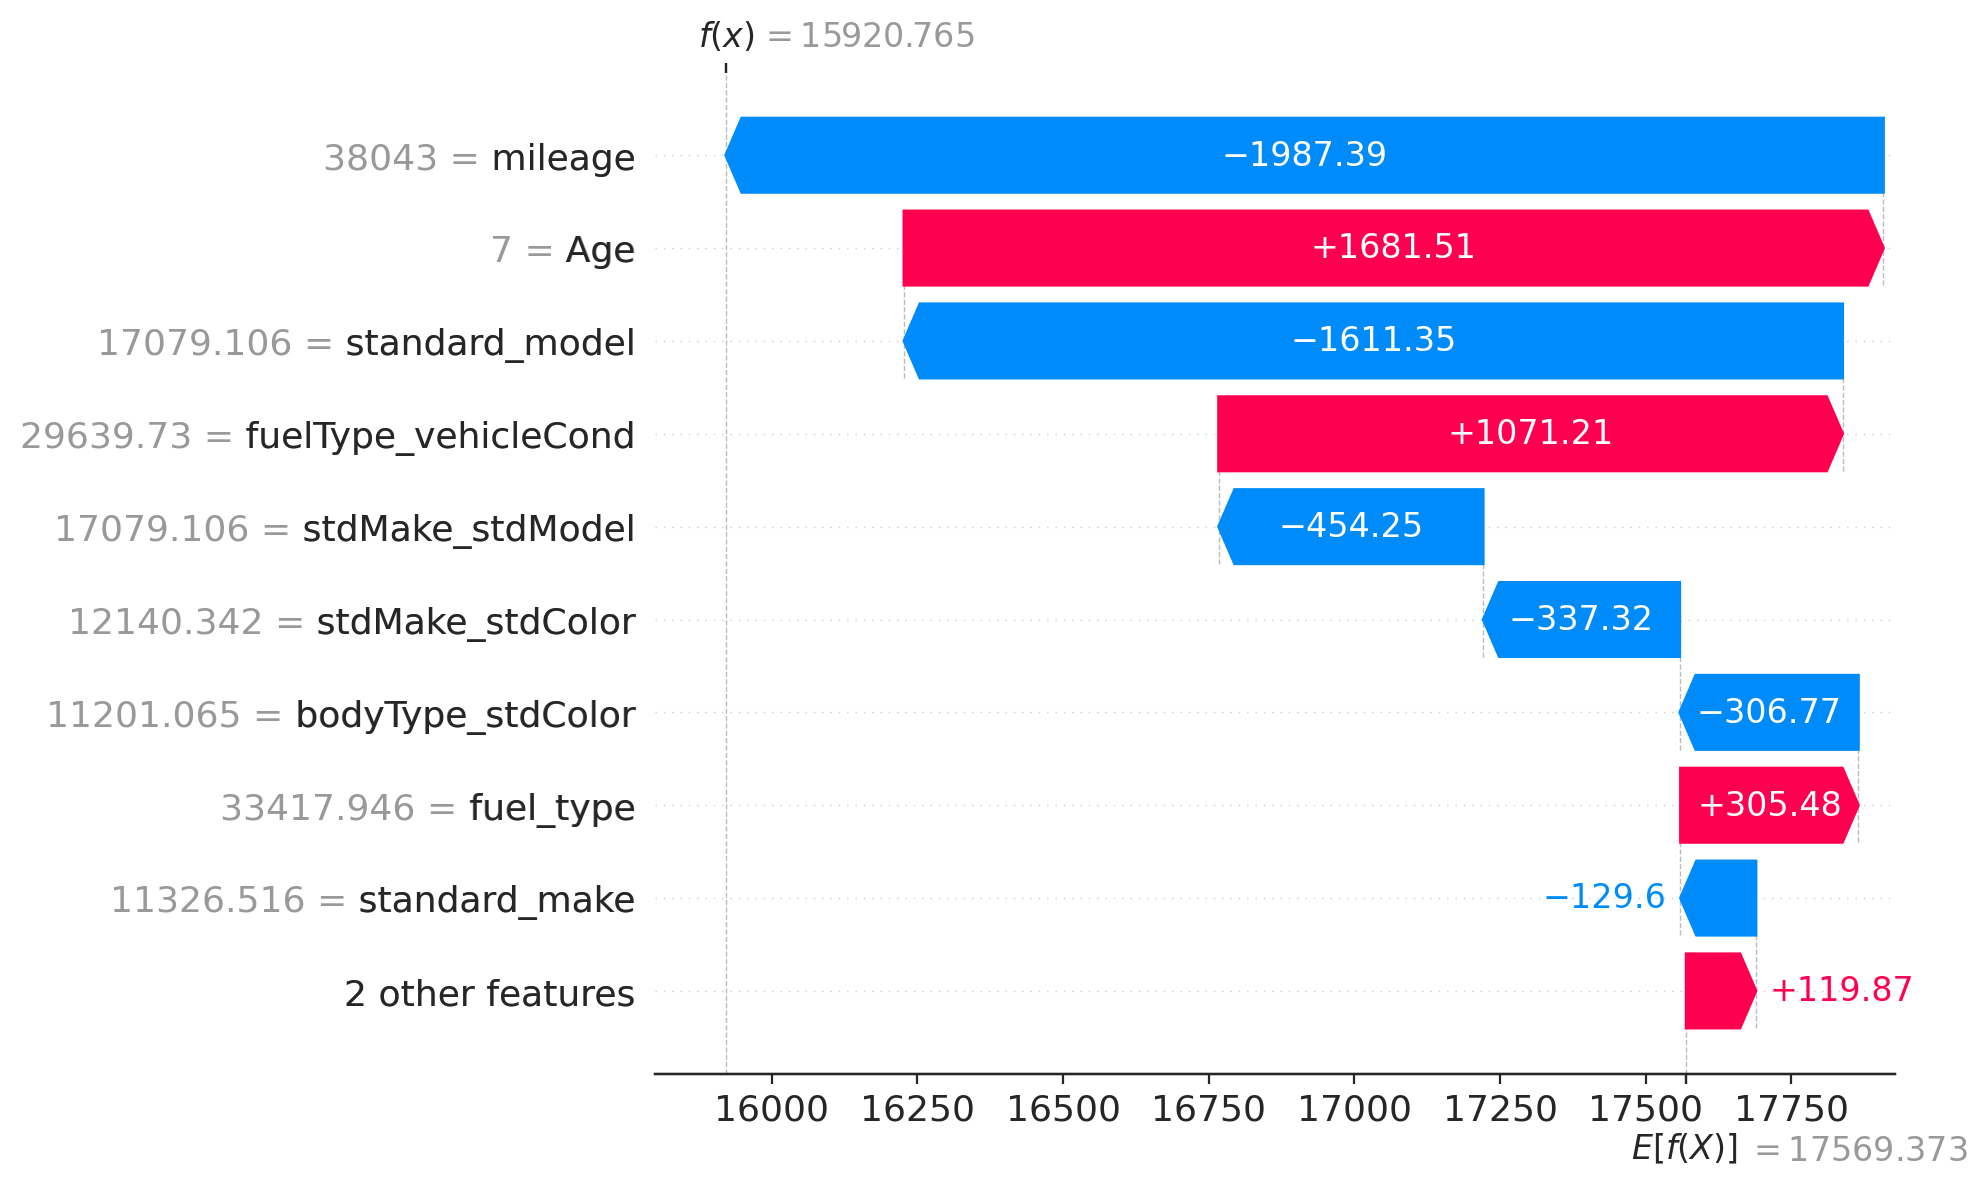

In [ ]:
shap.plots.waterfall(explanations[0, :])

In [ ]:
shap.initjs()
shap.plots.force(explanations[0, :])

**SHAP Values and Global Explanations**

In [ ]:
shap_values = explainer.shap_values(X_test_pp, check_additivity=False)

 98%|===================| 17698/18090 [00:18<00:00]       

In [ ]:
shap_values_df = pd.DataFrame(
    shap_values[:], columns=column_names, index=X_test.index
)

In [ ]:
shap_values_df.head()

,mileage,Age,standard_colour,standard_make,standard_model,body_type,fuel_type,fuelType_vehicleCond,bodyType_stdColor,stdMake_stdModel,stdMake_stdColor
119188,-7560.763011,-2754.151901,0.000000,1845.326990,-1551.198512,673.249863,-21.565737,-274.503695,1366.617666,613.872090,-109.317202
301456,8221.962527,1063.600215,31.032166,-11.598049,-1628.781548,372.998523,123.832762,-133.607305,-311.939885,148.043149,-438.759556
106393,-6581.959746,-3453.180674,0.000000,1796.156176,-1413.784683,701.853836,-0.532987,-264.660834,1043.525799,-1214.732488,856.866676
320391,-1363.790219,-238.938588,0.000000,573.617612,-1662.065609,232.894440,-35.363626,-287.904727,-245.345308,-2882.138766,-46.968862
81908,-14483.365702,-6001.420189,-248.257324,-2887.815473,13158.681939,-464.501104,-100.886095,-500.456180,-233.243746,11246.421820,1503.296472


In [ ]:
X_test[column_names].head()

,mileage,Age,standard_colour,standard_make,standard_model,body_type,fuel_type,fuelType_vehicleCond,bodyType_stdColor,stdMake_stdModel,stdMake_stdColor
119188,96000.0,13.0,Red,Audi,A5,Coupe,Diesel,Diesel_USED,Coupe_Red,Audi_A5,Audi_Red
301456,3010.0,4.0,Silver,Toyota,Corolla,Estate,Petrol Hybrid,Petrol Hybrid_USED,Estate_Silver,Toyota_Corolla,Toyota_Silver
106393,61000.0,18.0,Black,BMW,3 Series,Convertible,Petrol,Petrol_USED,Convertible_Black,BMW_3 Series,BMW_Black
320391,29000.0,9.0,Grey,DS AUTOMOBILES,DS 4,Hatchback,Diesel,Diesel_USED,Hatchback_Grey,DS AUTOMOBILES_DS 4,DS AUTOMOBILES_Grey
81908,103100.0,20.0,Black,Land Rover,Range Rover,SUV,Diesel,Diesel_USED,SUV_Black,Land Rover_Range Rover,Land Rover_Black


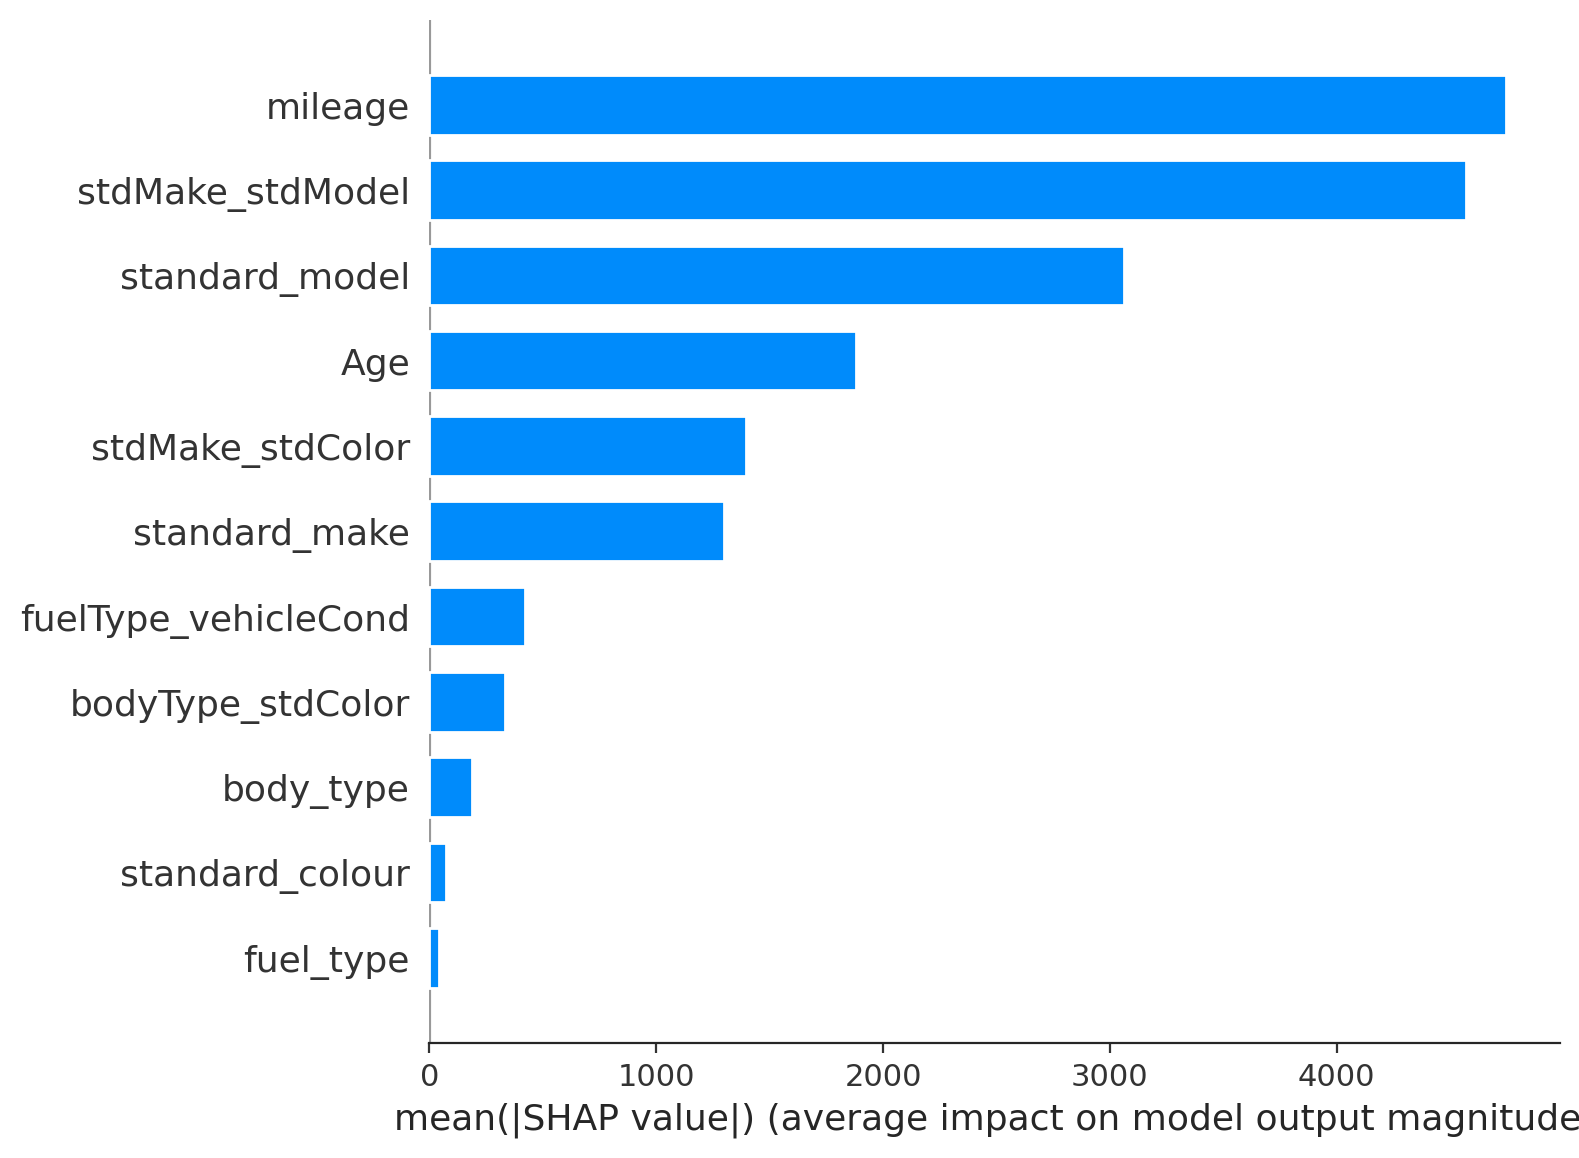

In [ ]:
# a global explanation: mean absolute SHAP as feature importance
shap.summary_plot(explanations[:,:], plot_type="bar")

## **Partial Dependency Plots**

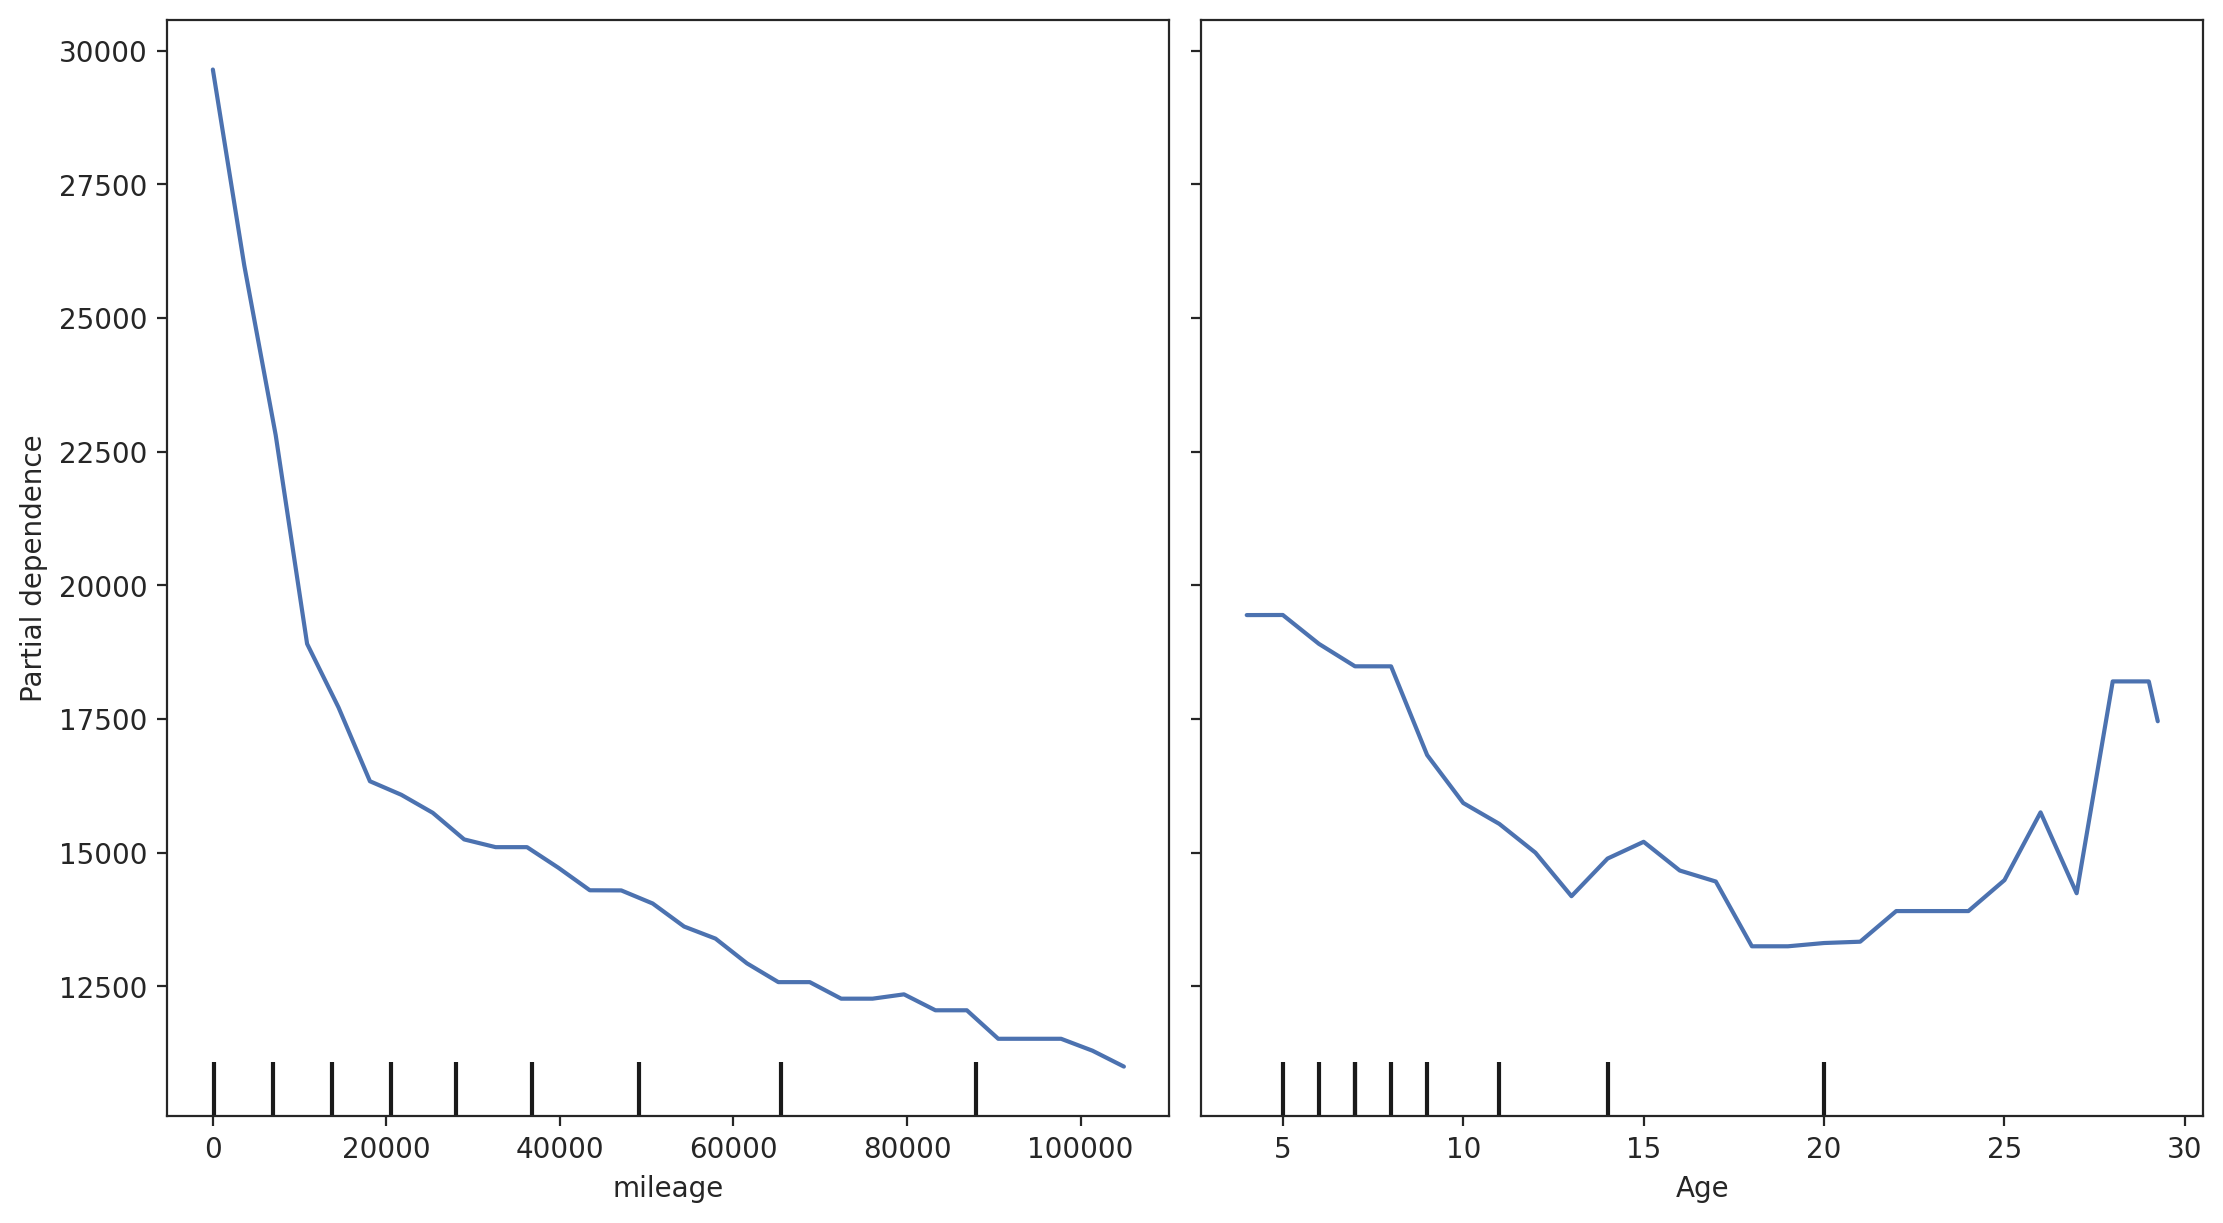

In [ ]:
fig, ax = plt.subplots(figsize=(11,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    estimator, X_test, features=['mileage', 'Age'],
    kind='average',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=12,
    ax=ax, n_cols=2
);